In [ ]:
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
from datetime import date, time, timedelta
import datetime as dt
import time
import json
import ast
from calendar import monthrange
import pytz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_squared_error, log_loss
import statsmodels.api as sm
from sklearn import tree
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve,  classification_report, recall_score, precision_score
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

### Data Ingestion & Cleaning

In [ ]:
df = pd.read_csv('data.csv')

In [ ]:
df.Churn.value_counts()

Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [ ]:
df.head(2)

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   

      PaymentMethod MonthlyCharges  TotalCharges Churn  
0  Electronic check          29.85         29.85    No  
1      Mailed check          56.95        1889.5    No  

[2 rows x 21 columns]

In [ ]:
#Processing trailing & leading spaces
string_cols = df.select_dtypes(include = ['object', 'string']).columns
df[string_cols] = df[string_cols].apply(lambda x: x.str.strip())

In [ ]:
df.describe()

SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000

In [ ]:
df.isna().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [ ]:
print("Before:", df.shape)
df = df.drop_duplicates()
print("After:", df.shape)

Before: (7043, 21)
After: (7043, 21)


### Creating Dummies

In [ ]:
df.MultipleLines.unique()
df.MultipleLines = df.MultipleLines.replace('No phone service', 'No')

df.InternetService = df.InternetService.replace('Fiber optic', 'Fiber_Optic') #Keeping this as a multiple categorical variable instead of binary

df.OnlineSecurity.unique()
df.OnlineSecurity = df.OnlineSecurity.replace('No internet service', 'No')

df.OnlineBackup.unique()
df.OnlineBackup = df.OnlineBackup.replace('No internet service', 'No')

df.DeviceProtection.unique()
df.DeviceProtection = df.DeviceProtection.replace('No internet service', 'No')

df.TechSupport.unique()
df.TechSupport = df.TechSupport.replace('No internet service', 'No')

df.StreamingTV.unique()
df.StreamingTV = df.StreamingTV.replace('No internet service', 'No')

df.StreamingMovies.unique()
df.StreamingMovies = df.StreamingMovies.replace('No internet service', 'No')

df.Contract = df.Contract.replace(['Month-to-month', 'One year', 'Two year'],
                                 ['Month_to_month', 'One_Year', 'Two_Year']) #Keeping this as a multiple categorical variable instead of binary

df.PaymentMethod = df.PaymentMethod.replace(['Electronic check', 'Mailed check', 'Bank transfer (automatic)', 'Credit card (automatic)'],
                                            ['Electronic_Check', 'Mailed_Check', 'Bank_Transfer', 'Credit_Card']) #Keeping this as a multiple categorical variable instead of binary

#Adding a fresh column to account for automatic/non-automatic payment methods
df['Automatic_Payment_Method'] = 0
df.loc[(df.PaymentMethod.isin(['Bank_Transfer', 'Credit_Card'])), 'Automatic_Payment_Method'] = 1

df.Churn = df.Churn.replace(['Yes', 'No'], [1, 0])

In [ ]:
df2 = pd.get_dummies(
    df,
    columns=['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'InternetService', 'Contract', 'PaymentMethod', 'Automatic_Payment_Method', 'PaperlessBilling'],
    prefix=['gender_', 'SeniorCitizen_', 'Partner_', 'Dependents_', 'PhoneService_', 'MultipleLines_', 'OnlineSecurity', 'OnlineBackup_', 'DeviceProtection_', 'TechSupport_', 'StreamingTV_', 'StreamingMovies_', 'InternetService_', 'Contract_', 'PaymentMethod_', 'Automatic_Payment_Method_', 'PaperlessBilling_'],
    drop_first = True,
    dtype = 'int'
)

df2 = df2.rename(columns = {'SeniorCitizen__1': 'Is_Senior_Citizen', 'gender__Male': 'Is_Male', 'Partner__Yes': 'Has_Partner', 'Dependents__Yes': 'Has_Dependents', 'PhoneService__Yes': 'Has_Phone_Service', 'MultipleLines__Yes': 'Has_Multiple_Lines', 'OnlineSecurity_Yes': 'Has_Online_Security', 'OnlineBackup__Yes': 'Has_Online_Backup', 'DeviceProtection__Yes': 'Has_Device_Protection', 'TechSupport__Yes': 'Has_Tech_Support', 'StreamingTV__Yes': 'Has_Streaming_TV', 'StreamingMovies__Yes': 'Has_Streaming_Movies', 'InternetService__Fiber_Optic': 'Has_Fiber_Optic_Internet', 'InternetService__No': 'Doesnt_Have_Internet_Service', 'Contract__One_Year': 'One_Year_Contract', 'Contract__Two_Year': 'Two_Year_Contract', 'PaymentMethod__Credit_Card': 'CC_Payment', 'PaymentMethod__Electronic_Check': 'EC_Payment', 'PaymentMethod__Mailed_Check': 'MC_Payment', 'PaperlessBilling__Yes': 'Has_Paperless_Billing', 'Automatic_Payment_Method__1': 'Uses_Auto_Payment'})

In [ ]:
#We have 11 rows with $0 in total charges - All seem to be new customers, as tenure = 0, and they haven't churned
df2[df2.TotalCharges == '']

#Easiest way to clean these is to drop the values
df2 = df2[df2.TotalCharges != '']

In [ ]:
df2.to_csv('Cleaned_Dataset.csv', index = False)

### Data Preprocessing for Modelling

In [ ]:
df = df2.copy()

In [ ]:
df.TotalCharges = df.TotalCharges.astype(float)

In [ ]:
df = df.drop('customerID', axis = 1)

In [ ]:
#=========================================================
#Train-test split
#=========================================================

X = df.drop(columns = ["Churn"])
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    random_state = 42
)

In [ ]:
#=========================================================
#Scaling numerical columns
#=========================================================
num_cols = X.select_dtypes(include=["int64", "float64"]).columns

# Copy for scaled versions
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

scaler = StandardScaler()
X_train_scaled[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test_scaled[num_cols] = scaler.transform(X_test[num_cols])

### Logistic Regression

Scaled Model

In [ ]:
# --- 1. Data Loading and Preprocessing ---
df = pd.read_csv("Cleaned_Dataset.csv")
# Handle 'TotalCharges': Convert to numeric and fill NaNs with 0
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)
# Drop identifier column
df = df.drop('customerID', axis=1)

X = df.drop('Churn', axis=1)
y = df['Churn']
# --- 2. Data Splitting (Train/Validation 80/20) ---
# X_train_raw and X_val_raw are the UNscaled data sets
X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define the custom evaluation loss function (FN Cost = 5, FP Cost = 1)
def evaluation_loss(y_true, y_pred_binary):
    fn = np.sum((y_true == 1) & (y_pred_binary == 0))
    fp = np.sum((y_true == 0) & (y_pred_binary == 1))
    return (100 * fn) + (10 * fp)
# --- 3. Scaling ---
num_cols = X_train_raw.select_dtypes(include=["int64", "float64"]).columns.tolist()
scaler = StandardScaler()

# Create Scaled DataFrames
X_train_scaled = X_train_raw.copy()
X_val_scaled = X_val_raw.copy()

# Fit scaler only on training data and transform both
X_train_scaled[num_cols] = scaler.fit_transform(X_train_raw[num_cols])
X_val_scaled[num_cols] = scaler.transform(X_val_raw[num_cols])
# --- 4. Model Training (Logistic Regression) ---

lr_scaled = LogisticRegression(max_iter=1000, random_state=42)
# Train on the SCALED data
lr_scaled.fit(X_train_scaled, y_train)

# Get prediction probabilities
y_train_pred_prob_lr_scaled = lr_scaled.predict_proba(X_train_scaled)[:, 1]
y_val_pred_prob_lr_scaled = lr_scaled.predict_proba(X_val_scaled)[:, 1]

# --- 5. Metric Calculation ---

train_mse = mean_squared_error(y_train, y_train_pred_prob_lr_scaled)
train_logloss = log_loss(y_train, y_train_pred_prob_lr_scaled)
val_auc = roc_auc_score(y_val, y_val_pred_prob_lr_scaled)

# --- 6. Optimal Threshold Selection ---

# Define the custom evaluation loss function (FN Cost = 5, FP Cost = 1)
def evaluation_loss(y_true, y_pred_binary):
    fn = np.sum((y_true == 1) & (y_pred_binary == 0))
    fp = np.sum((y_true == 0) & (y_pred_binary == 1))
    return (100 * fn) + (10 * fp)

# Search for the optimal threshold (0 to 1 with 101 steps)
thresholds = np.linspace(0, 1, 101)
min_loss = float('inf')
optimal_threshold = 0
loss_at_optimal_threshold = 0

for threshold in thresholds:
    # Convert probability to binary prediction
    y_pred_binary = (y_val_pred_prob_lr_scaled >= threshold).astype(int)
    current_loss = evaluation_loss(y_val, y_pred_binary)

    if current_loss < min_loss:
        min_loss = current_loss
        optimal_threshold = threshold
        loss_at_optimal_threshold = current_loss

# --- 7. Print Final Results ---
print("="*60)
print("       Logistic Regression Model Results (Scaled Data)")
print("="*60)
print(f"Validation AUC:                   {val_auc:.4f}")
print(f"Train L2 Loss (MSE):              {train_mse:.4f}")
print(f"Train Log Loss:                   {train_logloss:.4f}")
print("-" * 60)
print(f"Optimal Threshold:                {optimal_threshold:.2f}")
print(f"Minimum Evaluation Loss (100*FN+10*FP): {loss_at_optimal_threshold:.0f}")
print("="*60)

       Logistic Regression Model Results (Scaled Data)
Validation AUC:                   0.8357
Train L2 Loss (MSE):              0.1333
Train Log Loss:                   0.4115
------------------------------------------------------------
Optimal Threshold:                0.08
Minimum Evaluation Loss (100*FN+10*FP): 7090



Confusion Matrix for Scaled LR (Threshold: 0.08)
[[464 569]
 [ 14 360]]

----------------------------------------------------------------------
Classification Report (Precision, Recall, F1-Score)
----------------------------------------------------------------------
              precision    recall  f1-score   support

No Churn (0)       0.97      0.45      0.61      1033
   Churn (1)       0.39      0.96      0.55       374

    accuracy                           0.59      1407
   macro avg       0.68      0.71      0.58      1407
weighted avg       0.82      0.59      0.60      1407



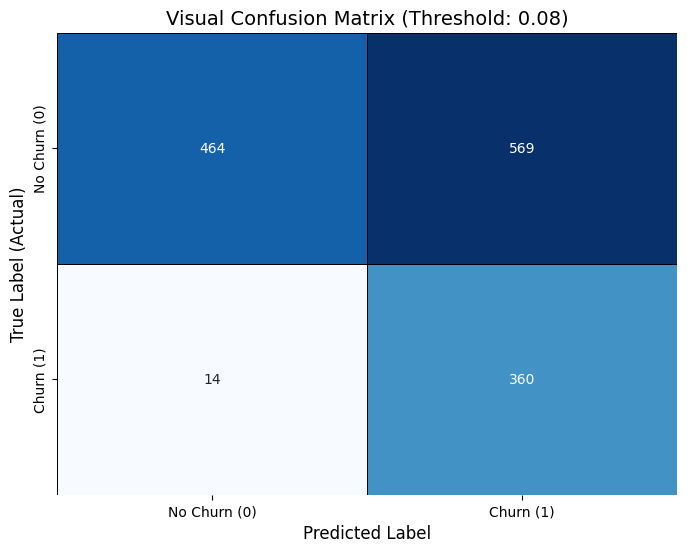

In [ ]:
# --- 7. Confusion Matrix and Classification Report ---

y_val_pred_binary = (y_val_pred_prob_lr_scaled >= optimal_threshold).astype(int)
cm = confusion_matrix(y_val, y_val_pred_binary)

print("\n" + "="*70)
print(f"Confusion Matrix for Scaled LR (Threshold: {optimal_threshold:.2f})")
print("="*70)
print(cm)

print("\n" + "-"*70)
print("Classification Report (Precision, Recall, F1-Score)")
print("-" * 70)
print(classification_report(
    y_val,
    y_val_pred_binary,
    target_names=['No Churn (0)', 'Churn (1)']
))
print("="*70)

# --- 8. Visual Confusion Matrix ---

labels = ['No Churn (0)', 'Churn (1)']

plt.figure(figsize=(8, 6))
sns.heatmap(cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=labels,
            yticklabels=labels,
            cbar=False,
            linewidths=0.5,
            linecolor='black')

plt.title(f'Visual Confusion Matrix (Threshold: {optimal_threshold:.2f})', fontsize=14)
plt.ylabel('True Label (Actual)', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add text labels for TN, FP, FN, TP
# Positioning the labels in the center of each cell
plt.text(0.5, 0.5, '', ha='center', va='center', color='black', fontsize=14)
plt.text(1.5, 0.5, '', ha='center', va='center', color='black', fontsize=14)
plt.text(0.5, 1.5, '', ha='center', va='center', color='black', fontsize=14)
plt.text(1.5, 1.5, '', ha='center', va='center', color='black', fontsize=14)

plt.show()

In [ ]:
import numpy as np
import pandas as pd

# --- Code to extract coefficients and match them to features ---

# 1. Retrieve the coefficients from the trained model (lr)
coefficients = lr_scaled.coef_[0]

# 2. Get the corresponding feature names from the training data
feature_names = X_train.columns

# 3. Create a DataFrame for easy viewing, including the Odds Ratio
interpretability_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds_Ratio': np.exp(coefficients)  # Calculate Odds Ratio (e^coefficient)
})

# 4. Print the raw coefficient table, sorted by magnitude for relevance
print("--- Logistic Regression(scaled) Coefficients and Odds Ratios ---")
interpretability_df['Abs_Coefficient'] = interpretability_df['Coefficient'].abs()
interpretability_df = interpretability_df.sort_values(by='Abs_Coefficient', ascending=False).drop('Abs_Coefficient', axis=1)

print(interpretability_df.to_markdown(index=False, floatfmt=".4f"))

--- Logistic Regression(scaled) Coefficients and Odds Ratios ---
| Feature                      |   Coefficient |   Odds_Ratio |
|:-----------------------------|--------------:|-------------:|
| tenure                       |       -1.3490 |       0.2595 |
| MonthlyCharges               |       -0.7722 |       0.4620 |
| Has_Fiber_Optic_Internet     |        0.6943 |       2.0023 |
| TotalCharges                 |        0.6412 |       1.8987 |
| Two_Year_Contract            |       -0.6020 |       0.5477 |
| Doesnt_Have_Internet_Service |       -0.5881 |       0.5554 |
| One_Year_Contract            |       -0.3111 |       0.7326 |
| Has_Streaming_TV             |        0.2369 |       1.2673 |
| Has_Streaming_Movies         |        0.2237 |       1.2507 |
| Has_Multiple_Lines           |        0.2077 |       1.2308 |
| Has_Paperless_Billing        |        0.1430 |       1.1537 |
| Has_Online_Security          |       -0.1428 |       0.8669 |
| Has_Tech_Support             |       

Unscaled Model

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, mean_squared_error, log_loss

# --- 1. Model Training (Logistic Regression on UNSCALED Data) ---

lr = LogisticRegression(max_iter=5000, random_state=42)
lr.fit(X_train, y_train)

# Get prediction probabilities
y_train_pred_prob_lr = lr.predict_proba(X_train)[:, 1]
y_val_pred_prob_lr = lr.predict_proba(X_test)[:, 1]

# --- 2. Metric Calculation ---

train_mse = mean_squared_error(y_train, y_train_pred_prob_lr)
train_logloss = log_loss(y_train, y_train_pred_prob_lr)
val_auc = roc_auc_score(y_val, y_val_pred_prob_lr)

val_logloss = log_loss(y_val, y_val_pred_prob_lr)

# --- 3. Optimal Threshold Selection ---

# Define the custom evaluation loss function (FN Cost = 5, FP Cost = 1)
def evaluation_loss(y_true, y_pred_binary):
    fn = np.sum((y_true == 1) & (y_pred_binary == 0))
    fp = np.sum((y_true == 0) & (y_pred_binary == 1))
    return ( 100* fn) + (10 * fp)

# Search for the optimal threshold (0 to 1 with 101 steps)
thresholds = np.linspace(0, 1, 101)
min_loss = float('inf')
optimal_threshold = 0
loss_at_optimal_threshold = 0

for threshold in thresholds:
    # Convert probability to binary prediction
    y_pred_binary = (y_val_pred_prob_lr >= threshold).astype(int)
    current_loss = evaluation_loss(y_val, y_pred_binary)

    if current_loss < min_loss:
        min_loss = current_loss
        optimal_threshold = threshold
        loss_at_optimal_threshold = current_loss

# --- 4. Print Final Results ---
print("="*65)
print("     Logistic Regression Model Results (UNSCALED Data)")
print("="*65)
print(f"Validation AUC:                   {val_auc:.4f}")
print(f"Train L2 Loss (MSE):              {train_mse:.4f}")
print(f"Train Log Loss:                   {train_logloss:.4f}")
print(f"Validation Log Loss:                  {val_logloss:.4f}")
print("-" * 65)
print(f"Optimal Threshold:                {optimal_threshold:.2f}")
print(f"Minimum Evaluation Loss (100*FN+10*FP): {loss_at_optimal_threshold:.0f}")
print("="*65)

     Logistic Regression Model Results (UNSCALED Data)
Validation AUC:                   0.8362
Train L2 Loss (MSE):              0.1333
Train Log Loss:                   0.4116
Validation Log Loss:                  0.4271
-----------------------------------------------------------------
Optimal Threshold:                0.08
Minimum Evaluation Loss (100*FN+10*FP): 7130


In [ ]:
# --- Code to extract coefficients and match them to features ---

# 1. Retrieve the coefficients from the trained model (lr)
coefficients = lr.coef_[0]

# 2. Get the corresponding feature names from the training data
feature_names = X_train.columns

# 3. Create a DataFrame for easy viewing, including the Odds Ratio
interpretability_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients,
    'Odds_Ratio': np.exp(coefficients)  # Calculate Odds Ratio (e^coefficient)
})

# 4. Print the raw coefficient table, sorted by magnitude for relevance
print("--- Logistic Regression(unscaled) Coefficients and Odds Ratios  ---")
interpretability_df['Abs_Coefficient'] = interpretability_df['Coefficient'].abs()
interpretability_df = interpretability_df.sort_values(by='Abs_Coefficient', ascending=False).drop('Abs_Coefficient', axis=1)

print(interpretability_df.to_markdown(index=False, floatfmt=".4f"))

--- Logistic Regression(unscaled) Coefficients and Odds Ratios  ---
| Feature                      |   Coefficient |   Odds_Ratio |
|:-----------------------------|--------------:|-------------:|
| Two_Year_Contract            |       -1.3649 |       0.2554 |
| Doesnt_Have_Internet_Service |       -1.0736 |       0.3418 |
| Has_Fiber_Optic_Internet     |        1.0343 |       2.8132 |
| One_Year_Contract            |       -0.7473 |       0.4737 |
| Has_Phone_Service            |       -0.4175 |       0.6587 |
| Has_Online_Security          |       -0.3871 |       0.6790 |
| EC_Payment                   |        0.3648 |       1.4402 |
| Has_Multiple_Lines           |        0.3486 |       1.4170 |
| Has_Tech_Support             |       -0.3467 |       0.7070 |
| Has_Streaming_TV             |        0.3418 |       1.4075 |
| Has_Streaming_Movies         |        0.3137 |       1.3684 |
| Has_Paperless_Billing        |        0.2940 |       1.3418 |
| Has_Dependents               |    

Step Up Model

Running Step-Up Feature Selection...
Selected Features: ['tenure', 'Has_Online_Security', 'Has_Tech_Support', 'Has_Streaming_TV', 'Has_Streaming_Movies', 'Has_Fiber_Optic_Internet', 'Doesnt_Have_Internet_Service', 'One_Year_Contract', 'Two_Year_Contract', 'EC_Payment']
      Logistic Regression Model Results (Step-Up Selection)
Validation AUC:                   0.8262
Train L2 Loss (MSE):              0.1358
Train Log Loss:                   0.4167
Validation Log Loss:                  0.4376
-----------------------------------------------------------------
Optimal Threshold:                0.06
Minimum Evaluation Loss (100*FN+10*FP): 7580

ROC AUC Score: 0.8262

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.71      0.79      1033
           1       0.50      0.80      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73

<Figure size 800x600 with 0 Axes>

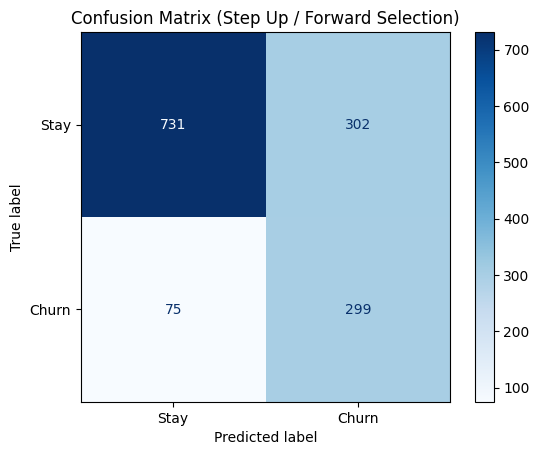

In [ ]:
X = df.drop(['Churn'], axis=1)
y = df['Churn']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

#Step-Up Feature Selection (Forward)
print("Running Step-Up Feature Selection...")
lr_selector = LogisticRegression(max_iter=2000, random_state=42, solver='liblinear')
sfs = SequentialFeatureSelector(lr_selector, n_features_to_select=10, direction='forward', scoring='roc_auc', cv=3)
sfs.fit(X_train, y_train)

selected_features = X.columns[sfs.get_support()]
print(f"Selected Features: {selected_features.tolist()}")

X_train_sel = sfs.transform(X_train)
X_val_sel = sfs.transform(X_val)

#Model Training (Logistic Regression on Selected Features)
lr = LogisticRegression(max_iter=2000, random_state=42, solver='liblinear')
lr.fit(X_train_sel, y_train)

y_pred_lr = log_reg.predict(X_test_scaled)


# Get prediction probabilities
y_train_pred_prob_lr = lr.predict_proba(X_train_sel)[:, 1]
y_val_pred_prob_lr = lr.predict_proba(X_val_sel)[:, 1]

#Metric Calculation
train_mse = mean_squared_error(y_train, y_train_pred_prob_lr)
train_logloss = log_loss(y_train, y_train_pred_prob_lr)
val_auc = roc_auc_score(y_val, y_val_pred_prob_lr)
val_logloss = log_loss(y_val, y_val_pred_prob_lr)

# Optimal Threshold Selection
# Custom penalties: FN (Churn as Stay) = 100, FP (Stay as Churn) = 10
def evaluation_loss(y_true, y_pred_binary):
    fn = np.sum((y_true == 1) & (y_pred_binary == 0))
    fp = np.sum((y_true == 0) & (y_pred_binary == 1))
    return (100 * fn) + (10 * fp)

thresholds = np.linspace(0, 1, 101)
min_loss = float('inf')
optimal_threshold = 0
loss_at_optimal_threshold = 0

for threshold in thresholds:
    y_pred_binary = (y_val_pred_prob_lr >= threshold).astype(int)
    current_loss = evaluation_loss(y_val, y_pred_binary)

    if current_loss < min_loss:
        min_loss = current_loss
        optimal_threshold = threshold
        loss_at_optimal_threshold = current_loss

# Print Final Results
print("="*65)
print("      Logistic Regression Model Results (Step-Up Selection)")
print("="*65)
print(f"Validation AUC:                   {val_auc:.4f}")
print(f"Train L2 Loss (MSE):              {train_mse:.4f}")
print(f"Train Log Loss:                   {train_logloss:.4f}")
print(f"Validation Log Loss:                  {val_logloss:.4f}")
print("-" * 65)
print(f"Optimal Threshold:                {optimal_threshold:.2f}")
print(f"Minimum Evaluation Loss (100*FN+10*FP): {loss_at_optimal_threshold:.0f}")
print("="*65)

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_val_pred_prob_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_lr,
    display_labels=['Stay', 'Churn'],
    cmap='Blues'
)
plt.title('Confusion Matrix (Step Up / Forward Selection)')
plt.savefig('logistic_forward_coefficients_confusion_matrix.png')

In [ ]:
coefficients_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': lr.coef_[0],
    'Odds_Ratio': np.exp(lr.coef_[0])
}).sort_values(by='Coefficient', ascending=False)

print("\nLogistic Regression step up Coefficients:")
print(coefficients_df.to_markdown(index=False))


Logistic Regression step up Coefficients:
| Feature                      |   Coefficient |   Odds_Ratio |
|:-----------------------------|--------------:|-------------:|
| Has_Fiber_Optic_Internet     |     0.922238  |     2.51491  |
| Has_Streaming_Movies         |     0.375681  |     1.45598  |
| EC_Payment                   |     0.374135  |     1.45373  |
| Has_Streaming_TV             |     0.339933  |     1.40485  |
| tenure                       |    -0.0316718 |     0.968825 |
| Has_Tech_Support             |    -0.424786  |     0.65391  |
| Has_Online_Security          |    -0.454276  |     0.634907 |
| One_Year_Contract            |    -0.851833  |     0.426632 |
| Doesnt_Have_Internet_Service |    -0.968862  |     0.379515 |
| Two_Year_Contract            |    -1.38834   |     0.249489 |


Step Down Model

Selected Features (Backward Elimination): ['tenure', 'TotalCharges', 'Has_Phone_Service', 'Has_Online_Security', 'Has_Tech_Support', 'Has_Fiber_Optic_Internet', 'Doesnt_Have_Internet_Service', 'One_Year_Contract', 'Two_Year_Contract', 'EC_Payment']
      Logistic Regression Model Results (Step-down Selection)
Validation AUC:                   0.8024
Train L2 Loss (MSE):              0.1653
Train Log Loss:                   0.4895
Validation Log Loss:                  0.5201
-----------------------------------------------------------------
Optimal Threshold:                0.04
Minimum Evaluation Loss (100*FN+10*FP): 8430

ROC AUC Score: 0.8024

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.71      0.79      1033
           1       0.50      0.80      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.80      0.73      0.75      140

<Figure size 800x600 with 0 Axes>

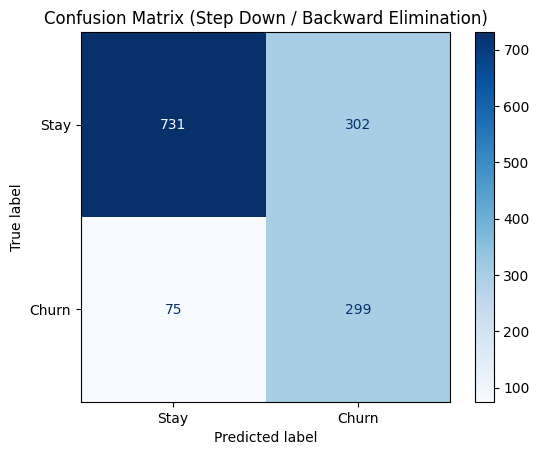

In [ ]:
X = df.drop(['Churn'], axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Setup "Step Down" (Backward Elimination) Logistic Regression
# direction='backward' starts with ALL features and removes the worst ones.
lr = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear', random_state=42)

# We select the top 10 features, optimizing for AUC.
sfs_backward = SequentialFeatureSelector(lr, n_features_to_select=10, direction='backward', scoring='roc_auc', cv=3)
sfs_backward.fit(X_train, y_train)

#Get Selected Features
selected_indices = sfs_backward.get_support()
selected_features = X.columns[selected_indices]
print("Selected Features (Backward Elimination):", selected_features.tolist())

# Train Final Model on Selected Features
X_train_sel = sfs_backward.transform(X_train)
X_test_sel = sfs_backward.transform(X_test)
lr.fit(X_train_sel, y_train)
y_pred_lr = log_reg.predict(X_test_scaled)

# Evaluate
y_train_pred_prob_lr = lr.predict_proba(X_train_sel)[:, 1]
y_val_pred_prob_lr = lr.predict_proba(X_val_sel)[:, 1]

# Metric Calculation
train_mse = mean_squared_error(y_train, y_train_pred_prob_lr)
train_logloss = log_loss(y_train, y_train_pred_prob_lr)
val_auc = roc_auc_score(y_val, y_val_pred_prob_lr)
val_logloss = log_loss(y_val, y_val_pred_prob_lr)

# Optimal Threshold Selection
# Custom penalties: FN (Churn as Stay) = 100, FP (Stay as Churn) = 10
def evaluation_loss(y_true, y_pred_binary):
    fn = np.sum((y_true == 1) & (y_pred_binary == 0))
    fp = np.sum((y_true == 0) & (y_pred_binary == 1))
    return (100 * fn) + (10 * fp)

thresholds = np.linspace(0, 1, 101)
min_loss = float('inf')
optimal_threshold = 0
loss_at_optimal_threshold = 0

for threshold in thresholds:
    y_pred_binary = (y_val_pred_prob_lr >= threshold).astype(int)
    current_loss = evaluation_loss(y_val, y_pred_binary)

    if current_loss < min_loss:
        min_loss = current_loss
        optimal_threshold = threshold
        loss_at_optimal_threshold = current_loss


print("="*65)
print("      Logistic Regression Model Results (Step-down Selection)")
print("="*65)
print(f"Validation AUC:                   {val_auc:.4f}")
print(f"Train L2 Loss (MSE):              {train_mse:.4f}")
print(f"Train Log Loss:                   {train_logloss:.4f}")
print(f"Validation Log Loss:                  {val_logloss:.4f}")
print("-" * 65)
print(f"Optimal Threshold:                {optimal_threshold:.2f}")
print(f"Minimum Evaluation Loss (100*FN+10*FP): {loss_at_optimal_threshold:.0f}")
print("="*65)

print(f"\nROC AUC Score: {roc_auc_score(y_test, y_val_pred_prob_lr):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lr))

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(
    y_test, y_pred_lr,
    display_labels=['Stay', 'Churn'],
    cmap='Blues'
)
plt.title('Confusion Matrix (Step Down / Backward Elimination)')
plt.savefig('logistic_backward_coefficients_confusion_matrix.png')

In [ ]:
coefficients_df = pd.DataFrame({
    'Feature': selected_features,
    'Coefficient': lr.coef_[0],
    'Odds_Ratio': np.exp(lr.coef_[0])
}).sort_values(by='Coefficient', ascending=False)

print("\nLogistic Regression step down Coefficients:")
print(coefficients_df.to_markdown(index=False))


Logistic Regression step down Coefficients:
| Feature                      |   Coefficient |   Odds_Ratio |
|:-----------------------------|--------------:|-------------:|
| Has_Fiber_Optic_Internet     |   0.878498    |     2.40728  |
| EC_Payment                   |   0.420532    |     1.52277  |
| TotalCharges                 |   0.000407674 |     1.00041  |
| tenure                       |  -0.0607056   |     0.9411   |
| Has_Tech_Support             |  -0.418698    |     0.657903 |
| Has_Online_Security          |  -0.478554    |     0.619679 |
| Has_Phone_Service            |  -0.570649    |     0.565159 |
| One_Year_Contract            |  -0.816774    |     0.441855 |
| Doesnt_Have_Internet_Service |  -0.935895    |     0.392235 |
| Two_Year_Contract            |  -1.44823     |     0.234985 |


### Decision Trees

======================================================= Decision Tree =======================================================
              precision    recall  f1-score   support

           0      0.830     0.858     0.844      1033
           1      0.568     0.516     0.541       374

    accuracy                          0.767      1407
   macro avg      0.699     0.687     0.692      1407
weighted avg      0.761     0.767     0.763      1407

ROC AUC: 0.8137078029310817

Confusion matrix:
 [[886 147]
 [181 193]]


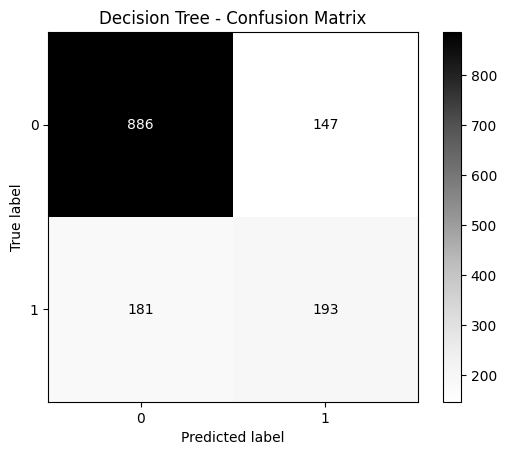

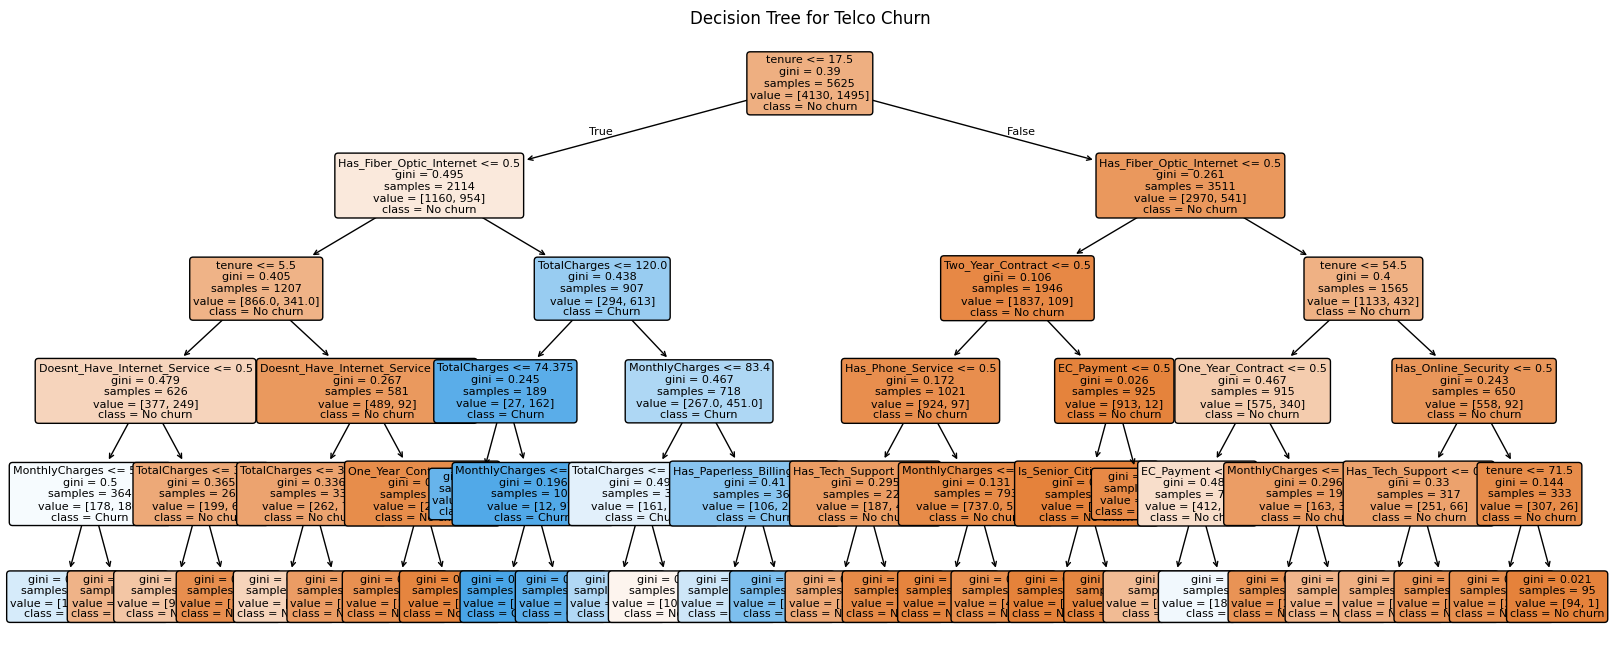

Optimal threshold for tree: 0.03
Minimum cost for tree: $7740.00


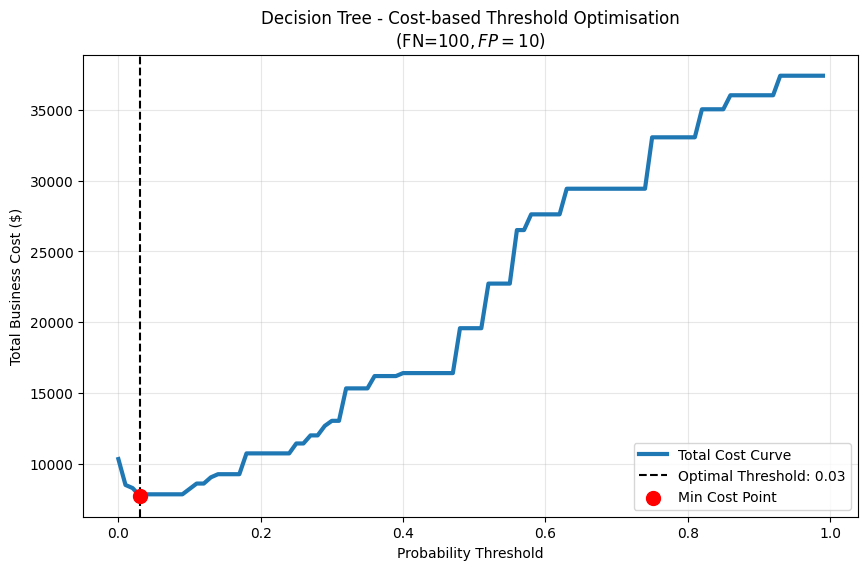

TN, FP, FN, TP: 319 714 6 368


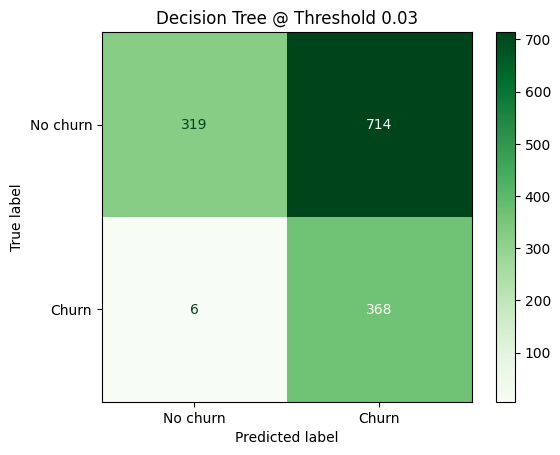

--- RESULTS ---
Optimal Threshold: 0.03
Minimum Total Cost: $7740

Metrics at this threshold:
Recall (Sensitivity): 0.98
Precision: 0.34
ROC-AUC: 0.8137

Confusion Matrix:
[[319 714]
 [  6 368]]


In [ ]:
#=========================================================
#Decision Tree - depth 5
#=========================================================
tree_model = DecisionTreeClassifier(
    max_depth = 5,
    min_samples_leaf = 50,
    random_state = 42
)
tree_model.fit(X_train, y_train) #As we don't need scaling here

y_pred_tree = tree_model.predict(X_test)
y_prob_tree = tree_model.predict_proba(X_test)[:, 1]

print("======================================================= Decision Tree =======================================================")
print(classification_report(y_test, y_pred_tree, digits = 3))
print("ROC AUC:", roc_auc_score(y_test, y_prob_tree))
print()

#================================================= Adding the confusion matrix ===============================================
#Predictions
y_pred_tree = tree_model.predict(X_test)

#Raw confusion matrix
cm = confusion_matrix(y_test, y_pred_tree)
print("Confusion matrix:\n", cm)

#Matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = tree_model.classes_)
disp.plot(cmap="Greys")
plt.title("Decision Tree - Confusion Matrix")
plt.show()


#================================================= The tree itself ===============================================
plt.figure(figsize=(20, 8))
tree.plot_tree(
    tree_model,
    feature_names=X_train.columns,
    class_names=["No churn", "Churn"],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Decision Tree for Telco Churn")
plt.show()

#================================================= Threshold optimisation for the tree ===============================================

#Getting predicted probabilities from tree
y_prob_tree = tree_model.predict_proba(X_test)[:, 1]

#Threshold optimisation
thresholds = np.arange(0.0, 1.0, 0.01)
costs = []

cost_fn = 100  # cost of missed churn
cost_fp = 10   # cost of wasted promo

for thresh in thresholds:
    y_pred_temp = (y_prob_tree >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    costs.append(total_cost)

min_cost_index = np.argmin(costs)
optimal_threshold_tree = thresholds[min_cost_index]
min_cost_tree = costs[min_cost_index]

print(f"Optimal threshold for tree: {optimal_threshold_tree:.2f}")
print(f"Minimum cost for tree: ${min_cost_tree:.2f}")

#Plotting cost vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, linewidth=3, label="Total Cost Curve")
plt.axvline(optimal_threshold_tree, color="black", linestyle="--",
            label=f"Optimal Threshold: {optimal_threshold_tree:.2f}")
plt.scatter(optimal_threshold_tree, min_cost_tree, color="red", s=100, zorder=5,
            label="Min Cost Point")

plt.xlabel("Probability Threshold")
plt.ylabel("Total Business Cost ($)")
plt.title("Decision Tree - Cost-based Threshold Optimisation\n(FN=$100, FP=$10)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


#Applying the optimal threshold
y_pred_tree_opt = (y_prob_tree >= optimal_threshold_tree).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tree_opt).ravel()
print("TN, FP, FN, TP:", tn, fp, fn, tp)

disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_tree_opt),
    display_labels=["No churn", "Churn"]
)
disp.plot(cmap = "Greens")
plt.title(f"Decision Tree @ Threshold {optimal_threshold_tree:.2f}")
plt.show()

#Final Results at Optimal Threshold
print(f"--- RESULTS ---")
print(f"Optimal Threshold: {optimal_threshold_tree:.2f}")
print(f"Minimum Total Cost: ${min_cost_tree}")
print(f"\nMetrics at this threshold:")
print(f"Recall (Sensitivity): {recall_score(y_test, y_pred_tree_opt):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_tree_opt):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_tree):.4f}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred_tree_opt)}")

======================================================= Decision Tree =======================================================
              precision    recall  f1-score   support

           0      0.837     0.876     0.856      1033
           1      0.607     0.529     0.566       374

    accuracy                          0.784      1407
   macro avg      0.722     0.703     0.711      1407
weighted avg      0.776     0.784     0.779      1407

ROC AUC: 0.8120033545407954

Confusion matrix:
 [[905 128]
 [176 198]]


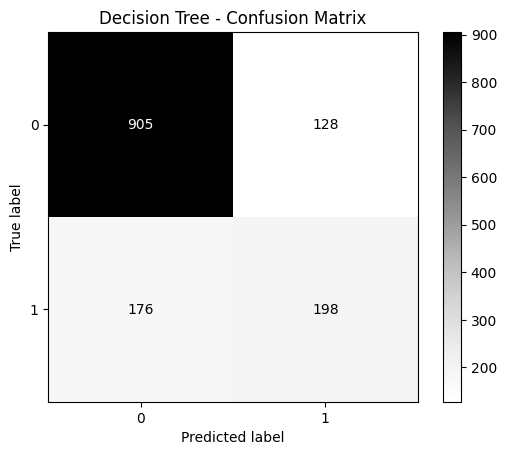

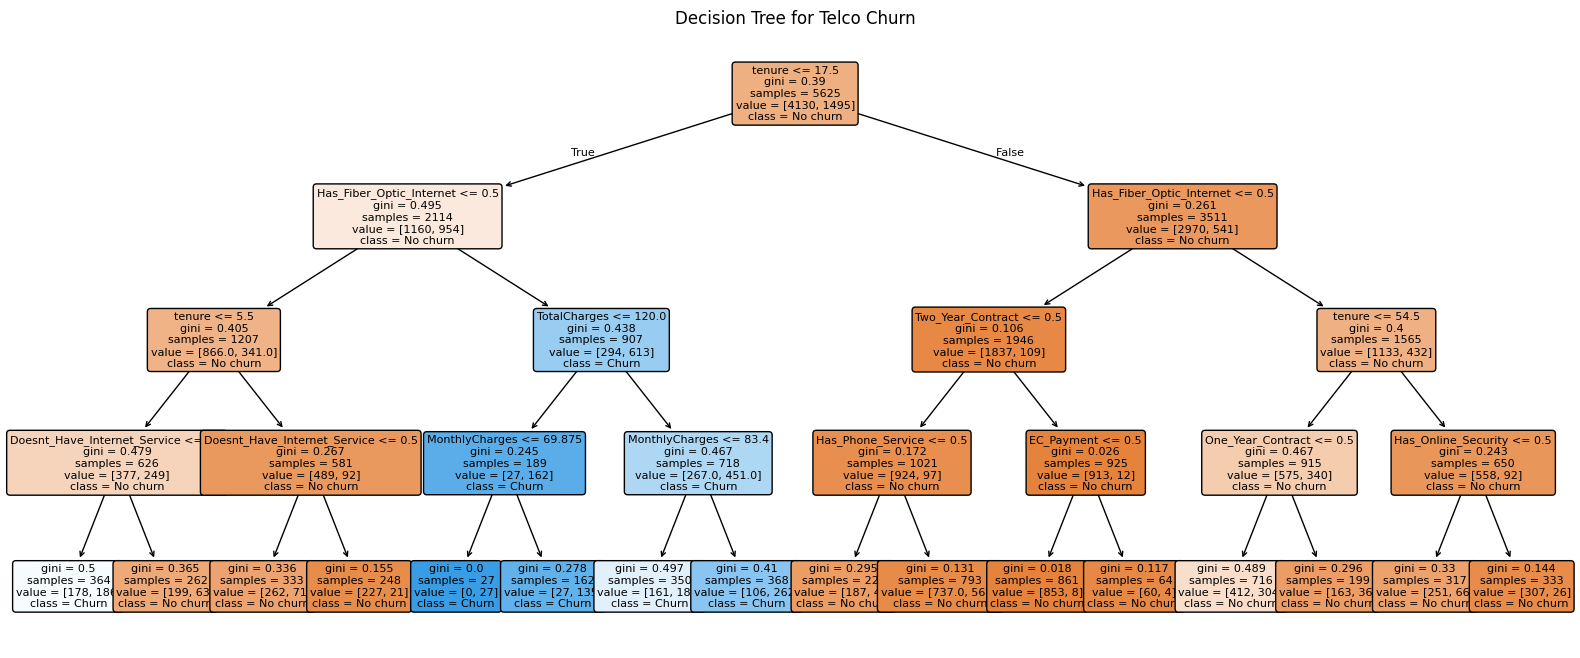

Optimal threshold for tree: 0.09
Minimum cost for tree: $8350.00


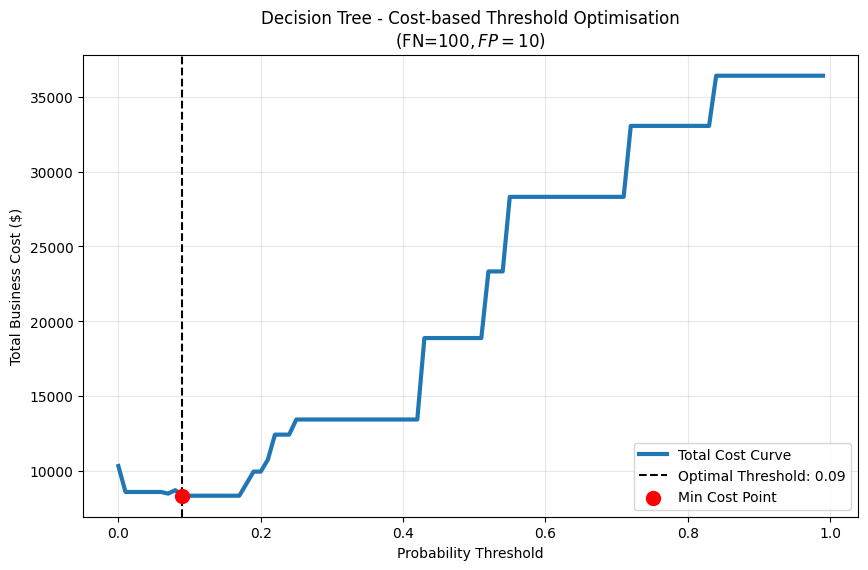

TN, FP, FN, TP: 538 495 34 340


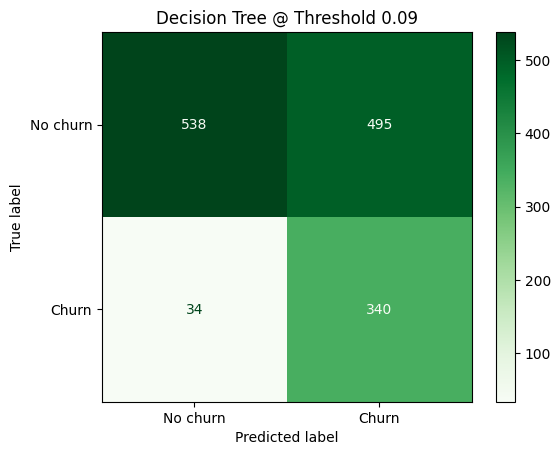

--- RESULTS ---
Optimal Threshold: 0.09
Minimum Total Cost: $8350

Metrics at this threshold:
Recall (Sensitivity): 0.91
Precision: 0.41
ROC-AUC: 0.8120

Confusion Matrix:
[[538 495]
 [ 34 340]]


In [ ]:
#=========================================================
#Decision Tree - depth 4
#=========================================================
tree_model = DecisionTreeClassifier(
    max_depth = 4,
    min_samples_leaf = 25,
    random_state = 42
)
tree_model.fit(X_train, y_train) #As we don't need scaling here

y_pred_tree = tree_model.predict(X_test)
y_prob_tree = tree_model.predict_proba(X_test)[:, 1]

print("======================================================= Decision Tree =======================================================")
print(classification_report(y_test, y_pred_tree, digits = 3))
print("ROC AUC:", roc_auc_score(y_test, y_prob_tree))
print()

#================================================= Adding the confusion matrix ===============================================
#Predictions
y_pred_tree = tree_model.predict(X_test)

#Raw confusion matrix
cm = confusion_matrix(y_test, y_pred_tree)
print("Confusion matrix:\n", cm)

#Matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = tree_model.classes_)
disp.plot(cmap="Greys")
plt.title("Decision Tree - Confusion Matrix")
plt.show()


#================================================= The tree itself ===============================================
plt.figure(figsize=(20, 8))
tree.plot_tree(
    tree_model,
    feature_names=X_train.columns,
    class_names=["No churn", "Churn"],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Decision Tree for Telco Churn")
plt.show()

#================================================= Threshold optimisation for the tree ===============================================

#Getting predicted probabilities from tree
y_prob_tree = tree_model.predict_proba(X_test)[:, 1]

#Threshold optimisation (Siddhart's code)
thresholds = np.arange(0.0, 1.0, 0.01)
costs = []

cost_fn = 100  # cost of missed churn
cost_fp = 10   # cost of wasted promo

for thresh in thresholds:
    y_pred_temp = (y_prob_tree >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    costs.append(total_cost)

min_cost_index = np.argmin(costs)
optimal_threshold_tree = thresholds[min_cost_index]
min_cost_tree = costs[min_cost_index]

print(f"Optimal threshold for tree: {optimal_threshold_tree:.2f}")
print(f"Minimum cost for tree: ${min_cost_tree:.2f}")

#Plotting cost vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, linewidth=3, label="Total Cost Curve")
plt.axvline(optimal_threshold_tree, color="black", linestyle="--",
            label=f"Optimal Threshold: {optimal_threshold_tree:.2f}")
plt.scatter(optimal_threshold_tree, min_cost_tree, color="red", s=100, zorder=5,
            label="Min Cost Point")

plt.xlabel("Probability Threshold")
plt.ylabel("Total Business Cost ($)")
plt.title("Decision Tree - Cost-based Threshold Optimisation\n(FN=$100, FP=$10)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


#Applying the optimal threshold
y_pred_tree_opt = (y_prob_tree >= optimal_threshold_tree).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tree_opt).ravel()
print("TN, FP, FN, TP:", tn, fp, fn, tp)

disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_tree_opt),
    display_labels=["No churn", "Churn"]
)
disp.plot(cmap = "Greens")
plt.title(f"Decision Tree @ Threshold {optimal_threshold_tree:.2f}")
plt.show()

#Final Results at Optimal Threshold
print(f"--- RESULTS ---")
print(f"Optimal Threshold: {optimal_threshold_tree:.2f}")
print(f"Minimum Total Cost: ${min_cost_tree}")
print(f"\nMetrics at this threshold:")
print(f"Recall (Sensitivity): {recall_score(y_test, y_pred_tree_opt):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_tree_opt):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_tree):.4f}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred_tree_opt)}")

======================================================= Decision Tree =======================================================
              precision    recall  f1-score   support

           0      0.809     0.929     0.865      1033
           1      0.670     0.396     0.497       374

    accuracy                          0.787      1407
   macro avg      0.740     0.663     0.681      1407
weighted avg      0.772     0.787     0.767      1407

ROC AUC: 0.7991158093088506

Confusion matrix:
 [[960  73]
 [226 148]]


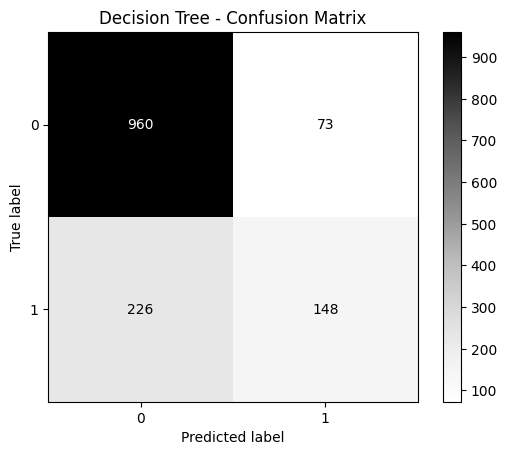

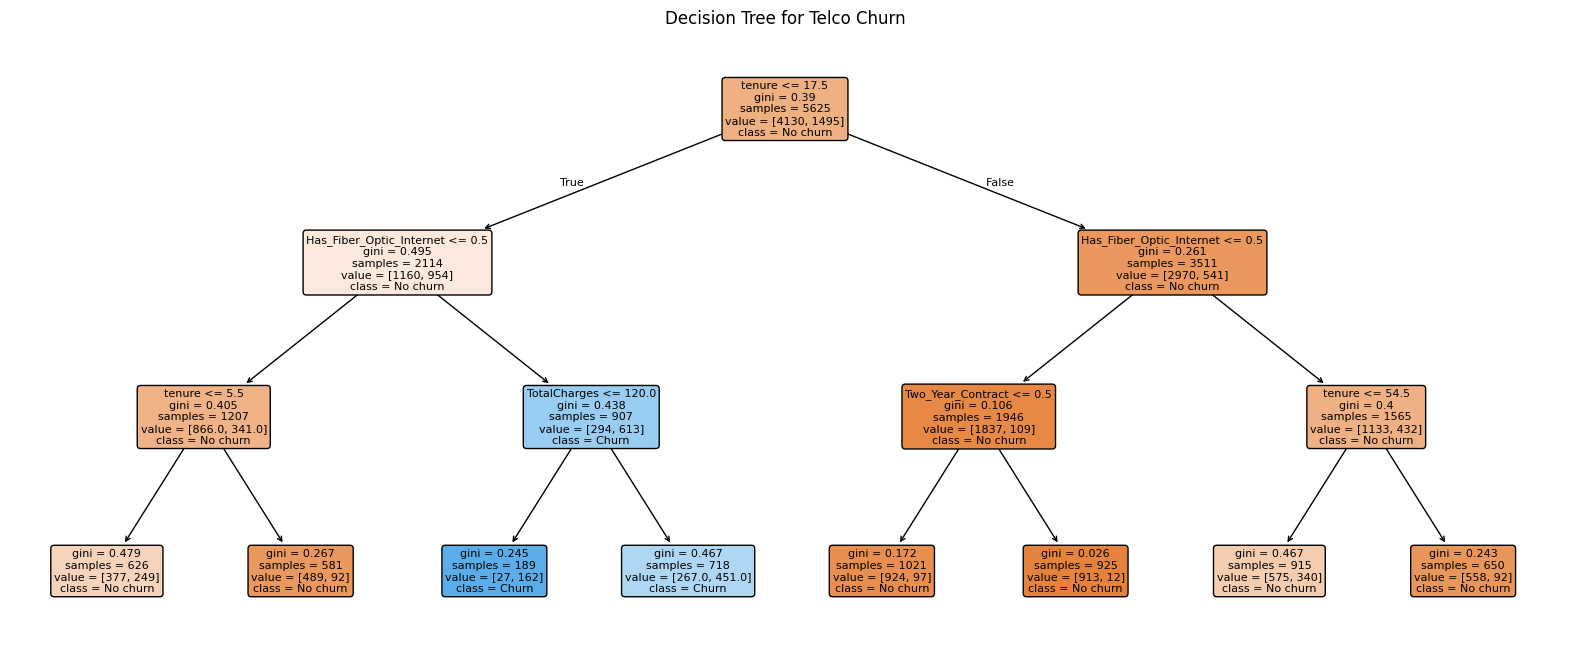

Optimal threshold for tree: 0.02
Minimum cost for tree: $8490.00


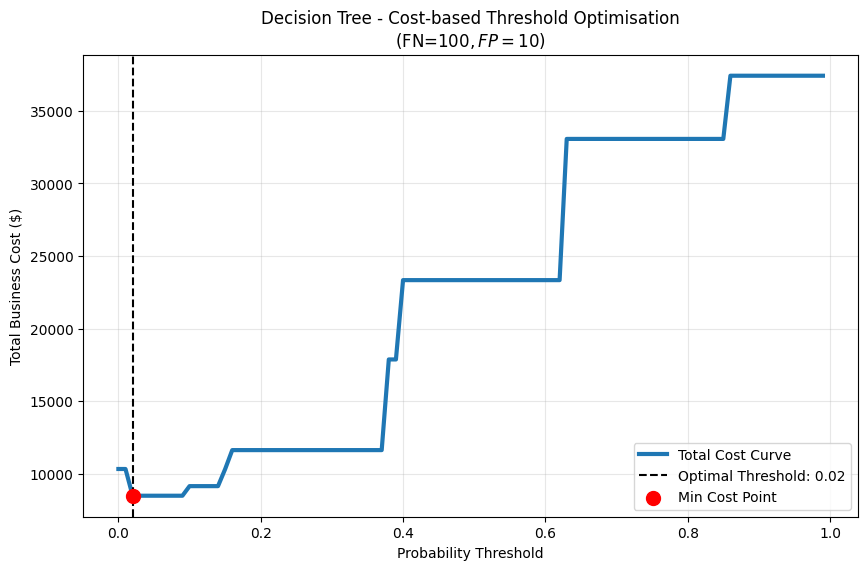

TN, FP, FN, TP: 234 799 5 369


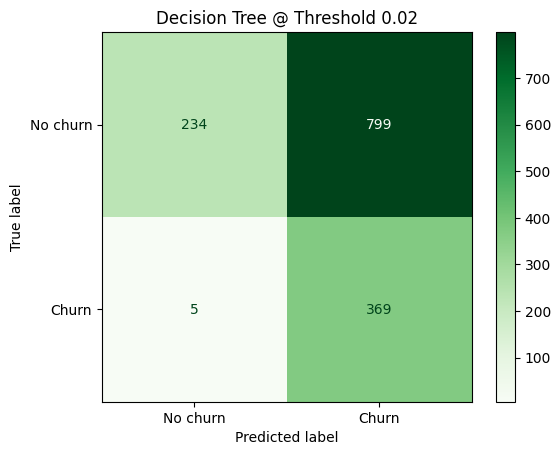

--- RESULTS ---
Optimal Threshold: 0.02
Minimum Total Cost: $8490

Metrics at this threshold:
Recall (Sensitivity): 0.99
Precision: 0.32
ROC-AUC: 0.7991

Confusion Matrix:
[[234 799]
 [  5 369]]


In [ ]:
#=========================================================
#Decision Tree - depth 3
#=========================================================
tree_model = DecisionTreeClassifier(
    max_depth = 3,
    min_samples_leaf = 25,
    random_state = 42
)
tree_model.fit(X_train, y_train) #As we don't need scaling here

y_pred_tree = tree_model.predict(X_test)
y_prob_tree = tree_model.predict_proba(X_test)[:, 1]

print("======================================================= Decision Tree =======================================================")
print(classification_report(y_test, y_pred_tree, digits = 3))
print("ROC AUC:", roc_auc_score(y_test, y_prob_tree))
print()

#================================================= Adding the confusion matrix ===============================================
#Predictions
y_pred_tree = tree_model.predict(X_test)

#Raw confusion matrix
cm = confusion_matrix(y_test, y_pred_tree)
print("Confusion matrix:\n", cm)

#Matrix plot
disp = ConfusionMatrixDisplay(confusion_matrix = cm,
                              display_labels = tree_model.classes_)
disp.plot(cmap="Greys")
plt.title("Decision Tree - Confusion Matrix")
plt.show()


#================================================= The tree itself ===============================================
plt.figure(figsize=(20, 8))
tree.plot_tree(
    tree_model,
    feature_names=X_train.columns,
    class_names=["No churn", "Churn"],
    filled=True,
    rounded=True,
    fontsize=8
)
plt.title("Decision Tree for Telco Churn")
plt.show()

#================================================= Threshold optimisation for the tree ===============================================

#Getting predicted probabilities from tree
y_prob_tree = tree_model.predict_proba(X_test)[:, 1]

#Threshold optimisation (Siddhart's code)
thresholds = np.arange(0.0, 1.0, 0.01)
costs = []

cost_fn = 100  # cost of missed churn
cost_fp = 10   # cost of wasted promo

for thresh in thresholds:
    y_pred_temp = (y_prob_tree >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    costs.append(total_cost)

min_cost_index = np.argmin(costs)
optimal_threshold_tree = thresholds[min_cost_index]
min_cost_tree = costs[min_cost_index]

print(f"Optimal threshold for tree: {optimal_threshold_tree:.2f}")
print(f"Minimum cost for tree: ${min_cost_tree:.2f}")

#Plotting cost vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, linewidth=3, label="Total Cost Curve")
plt.axvline(optimal_threshold_tree, color="black", linestyle="--",
            label=f"Optimal Threshold: {optimal_threshold_tree:.2f}")
plt.scatter(optimal_threshold_tree, min_cost_tree, color="red", s=100, zorder=5,
            label="Min Cost Point")

plt.xlabel("Probability Threshold")
plt.ylabel("Total Business Cost ($)")
plt.title("Decision Tree - Cost-based Threshold Optimisation\n(FN=$100, FP=$10)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


#Applying the optimal threshold
y_pred_tree_opt = (y_prob_tree >= optimal_threshold_tree).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_tree_opt).ravel()
print("TN, FP, FN, TP:", tn, fp, fn, tp)

disp = ConfusionMatrixDisplay(
    confusion_matrix=confusion_matrix(y_test, y_pred_tree_opt),
    display_labels=["No churn", "Churn"]
)
disp.plot(cmap = "Greens")
plt.title(f"Decision Tree @ Threshold {optimal_threshold_tree:.2f}")
plt.show()

#Final Results at Optimal Threshold
print(f"--- RESULTS ---")
print(f"Optimal Threshold: {optimal_threshold_tree:.2f}")
print(f"Minimum Total Cost: ${min_cost_tree}")
print(f"\nMetrics at this threshold:")
print(f"Recall (Sensitivity): {recall_score(y_test, y_pred_tree_opt):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_tree_opt):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_tree):.4f}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred_tree_opt)}")

### EBM

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
# ---------------------------

# --- 1. Load and Prepare Data ---
df = pd.read_csv("Cleaned_Dataset.csv")

# Drop the identifier column
df = df.drop('customerID', axis=1)

X = df.drop('Churn', axis=1)
y = df['Churn']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data Loaded and Split successfully.")

# --- 2. Train the EBM Model ---
print("\nTraining Explainable Boosting Machine...")
ebm = ExplainableBoostingClassifier(
    random_state=42,
    n_jobs=-1, # Use all available cores for faster training
)

ebm.fit(X_train, y_train)
print("Training complete.")

# --- 3. Evaluate the Model ---
y_pred_proba = ebm.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nModel ROC AUC on the test set: {roc_auc:.4f}")

# --- 4. Generate Global Explanation (Model Overview) ---
# This shows feature importance and the main effect plots for all features.
print("\nGenerating Global Explanation...")
ebm_global = ebm.explain_global(name='EBM Global Explanation - Churn')

# To view the interactive dashboard in a Jupyter Notebook:
print("\nUse the 'show(ebm_global)' command in a Jupyter environment to launch the dashboard.")
# show(ebm_global)


# --- 5. Generate Local Explanation (Single Prediction) ---
# Let's look at the first customer in the test set.
customer_to_explain = X_test.head(1)
actual_churn = y_test.head(1)

print("Generating Local Explanation for the first test sample...")
ebm_local = ebm.explain_local(
    customer_to_explain,
    actual_churn,
    name='EBM Local Explanation - Customer 1'
)

Data Loaded and Split successfully.

Training Explainable Boosting Machine...
Training complete.

Model ROC AUC on the test set: 0.8391

Generating Global Explanation...

Use the 'show(ebm_global)' command in a Jupyter environment to launch the dashboard.
Generating Local Explanation for the first test sample...


In [ ]:
from sklearn.metrics import mean_squared_error, log_loss
import numpy as np
y_train_pred_proba = ebm.predict_proba(X_train)[:, 1]
l2_train_loss = mean_squared_error(y_train, y_train_pred_proba)
log_train_loss = log_loss(y_train, y_train_pred_proba)
y_test_pred_proba = ebm.predict_proba(X_test)[:, 1]
l2_test_loss = mean_squared_error(y_test, y_test_pred_proba)
log_test_loss = log_loss(y_test, y_test_pred_proba)
print("\n--- Training Loss Metrics ---")
print(f"L2 Training Loss (MSE): {l2_train_loss:.4f}")
print(f"Log Training Loss (Binary Cross-Entropy): {log_train_loss:.4f}")
print(f"\n--- Test Loss Metrics ---")
print(f"L2 Test Loss (MSE): {l2_test_loss:.4f}")
print(f"Log Test Loss (Binary Cross-Entropy): {log_test_loss:.4f}")


--- Training Loss Metrics ---
L2 Training Loss (MSE): 0.1264
Log Training Loss (Binary Cross-Entropy): 0.3909

--- Test Loss Metrics ---
L2 Test Loss (MSE): 0.1384
Log Test Loss (Binary Cross-Entropy): 0.4222


In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix

# --- 1. Define the Cost Function ---
def calculate_cost(y_true, y_pred, cost_fn=100, cost_fp=10):
    """
    Calculates the total cost based on the confusion matrix.

    Cost = (Cost_FN * FN) + (Cost_FP * FP)
    """
    # Confusion Matrix: [[TN, FP], [FN, TP]]
    cm = confusion_matrix(y_true, y_pred)

    # Check if the matrix is 2x2, handle potential edge case
    if cm.shape == (2, 2):
        TN, FP, FN, TP = cm.ravel()
    elif cm.shape == (1, 1):
        return np.inf
    else:
        return np.inf

    total_cost = (cost_fn * FN) + (cost_fp * FP)
    return total_cost, FN, FP

# --- 2. Predict Probabilities (already done in step 3 of original code) ---
# y_pred_proba contains the predicted probability of CHURN (class 1)
# y_pred_proba = ebm.predict_proba(X_test)[:, 1]

# --- 3. Find the Optimal Threshold ---
# We use the unique probabilities as candidate thresholds for efficiency.
candidate_thresholds = np.sort(np.unique(y_pred_proba))

# Initialize variables to track the best result
min_cost = np.inf
optimal_threshold = 0.5
optimal_metrics = {'FN': 0, 'FP': 0}

for threshold in candidate_thresholds:
    # Convert probabilities to class predictions using the current threshold
    y_pred_class = (y_pred_proba >= threshold).astype(int)

    # Calculate the cost at this threshold
    current_cost, FN, FP = calculate_cost(y_test, y_pred_class, cost_fn=100, cost_fp=10)

    if current_cost < min_cost:
        min_cost = current_cost
        optimal_threshold = threshold
        optimal_metrics = {'FN': FN, 'FP': FP}

print("\n--- Training Loss Metrics ---")
print(f"L2 Training Loss (MSE): {l2_train_loss:.4f}")
print(f"Log Training Loss (Binary Cross-Entropy): {log_train_loss:.4f}")
print(f"\n--- Test Loss Metrics ---")
print(f"L2 Test Loss (MSE): {l2_test_loss:.4f}")
print(f"Log Test Loss (Binary Cross-Entropy): {log_test_loss:.4f}")
print(f"Optimal Threshold: {optimal_threshold:.4f}")
print(f"Minimum Total Loss: ${min_cost:.2f}")
print(f"False Negatives (FN): {optimal_metrics['FN']} (Cost: ${optimal_metrics['FN'] * 100})")
print(f"False Positives (FP): {optimal_metrics['FP']} (Cost: ${optimal_metrics['FP'] * 10})")


--- Training Loss Metrics ---
L2 Training Loss (MSE): 0.1264
Log Training Loss (Binary Cross-Entropy): 0.3909

--- Test Loss Metrics ---
L2 Test Loss (MSE): 0.1384
Log Test Loss (Binary Cross-Entropy): 0.4222
Optimal Threshold: 0.0360
Minimum Total Loss: $7180.00
False Negatives (FN): 3 (Cost: $300)
False Positives (FP): 688 (Cost: $6880)


EBM Global

In [ ]:
show(ebm_global)

This chart shows the EBM model's Global Feature Importances. Two-Year Contract and customer tenure are the most important predictors of churn. Following these top two, service features like having Fiber Optic Internet and the magnitude of Monthly Charges are the next most influential factors. Features with significantly less impact on the model's prediction include value-added services like Has Streaming TV, Has Online Backup and having Dependents.

The Main Effect Plot for tenure shows that churn risk is highest for new customers (low tenure), indicated by the positive score (around +1.0). The risk rapidly decreases as tenure increases past 20 months. For long-term customers (over 65 months), the risk is lowest, marked by a negative score (around -1.0), signifying strong retention.


EBM Local

In [ ]:
show(ebm_local)

This customer is correctly predicted by the EBM model to be a non-churner with a very high confidence of 98%. This robust retention forecast is overwhelmingly driven by three highly protective features: the Two-Year Contract, the customer's high tenure of 59 months, and the high cumulative Total Charges of $4,542.35. These positive factors, which strongly push the prediction away from churn, effectively neutralize the smaller churn-increasing risks associated with being a customer who does have internet service and having supplementary services like Paperless Billing and Online Backup.

### Multi-Layer Perceptron

======================================================= MLP Classifier =======================================================
              precision    recall  f1-score   support

           0      0.816     0.812     0.814      1033
           1      0.488     0.495     0.491       374

    accuracy                          0.728      1407
   macro avg      0.652     0.653     0.653      1407
weighted avg      0.729     0.728     0.728      1407

ROC AUC: 0.7266528102044302
Confusion Matrix:
 [[839 194]
 [189 185]]


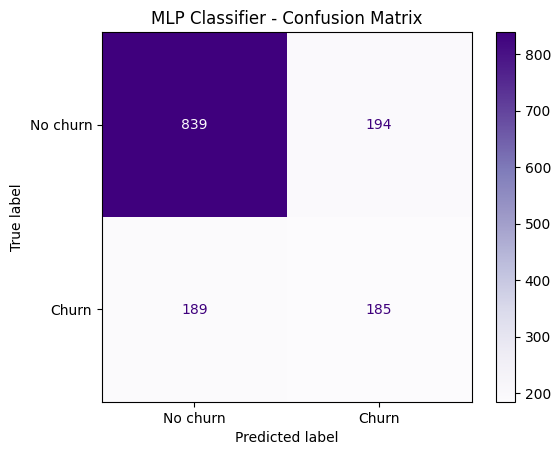

Optimal MLP threshold: 0.00
Minimum MLP cost: $10330.00


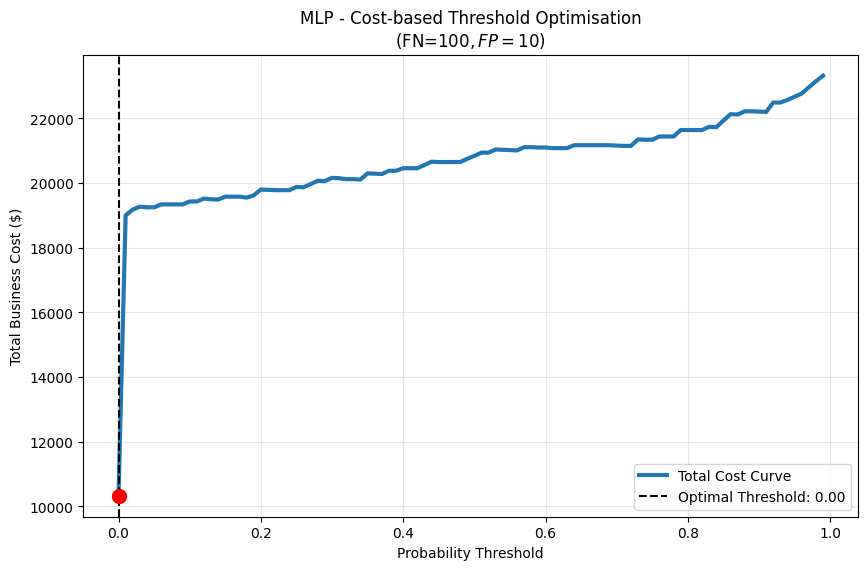

TN, FP, FN, TP: 0 1033 0 374


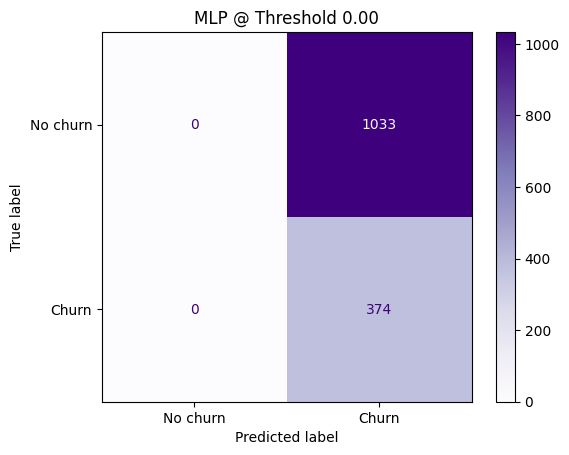

--- FINAL RESULTS (MLP) ---
Optimal Threshold: 0.00
Minimum Total Cost: $10330
Recall (Sensitivity): 1.00
Precision: 0.27
ROC-AUC: 0.7267

Confusion Matrix:
[[   0 1033]
 [   0  374]]


In [ ]:
#=========================================================
#Multi-Layer Perceptron: More layers, lbfgs solver, relu activation
#=========================================================
mlp_model = MLPClassifier(
    hidden_layer_sizes = (128, 64, 32),
    activation = "relu",
    solver = "lbfgs",
    learning_rate_init = 0.01,
    max_iter = 7500,
    early_stopping = True,
    n_iter_no_change = 20,
    random_state = 42
)
mlp_model.fit(X_train_scaled, y_train)

y_pred_mlp = mlp_model.predict(X_test_scaled)
y_prob_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]

print("======================================================= MLP Classifier =======================================================")
print(classification_report(y_test, y_pred_mlp, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_prob_mlp))

#================================================= Adding the confusion matrix ===============================================
#Predictions from the MLP
y_pred_mlp = mlp_model.predict(X_test_scaled)

#Raw confusion matrix
cm = confusion_matrix(y_test, y_pred_mlp)
print("Confusion Matrix:\n", cm)

#Heatmap
disp = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = ["No churn", "Churn"]
)

disp.plot(cmap = "Purples")
plt.title("MLP Classifier - Confusion Matrix")
plt.show()

#================================================= Threshold optimisation for the MLP ===============================================

#Getting predicted probabilities from tree
y_prob = y_prob_mlp

#Threshold optimisation
thresholds = np.arange(0.0, 1.0, 0.01)
costs = []

cost_fn = 100  # cost of missed churn
cost_fp = 10   # cost of wasted promo

for thresh in thresholds:
    y_pred_temp = (y_prob >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    costs.append(total_cost)

min_cost_index = np.argmin(costs)
optimal_threshold_mlp = thresholds[min_cost_index]
min_cost_mlp = costs[min_cost_index]

print(f"Optimal MLP threshold: {optimal_threshold_mlp:.2f}")
print(f"Minimum MLP cost: ${min_cost_mlp:.2f}")

#Plotting cost vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, linewidth=3, label="Total Cost Curve")
plt.axvline(optimal_threshold_mlp, color="black", linestyle="--",
            label=f'Optimal Threshold: {optimal_threshold_mlp:.2f}')
plt.scatter(optimal_threshold_mlp, min_cost_mlp, color="red", s=100, zorder=5)
plt.xlabel("Probability Threshold")
plt.ylabel("Total Business Cost ($)")
plt.title("MLP - Cost-based Threshold Optimisation\n(FN=$100, FP=$10)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#Applying the optimal threshold
y_pred_mlp_opt = (y_prob >= optimal_threshold_mlp).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_mlp_opt).ravel()
print("TN, FP, FN, TP:", tn, fp, fn, tp)

disp = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test, y_pred_mlp_opt),
    display_labels = ["No churn", "Churn"]
)
disp.plot(cmap="Purples")
plt.title(f"MLP @ Threshold {optimal_threshold_mlp:.2f}")
plt.show()

print(f"--- FINAL RESULTS (MLP) ---")
print(f"Optimal Threshold: {optimal_threshold_mlp:.2f}")
print(f"Minimum Total Cost: ${min_cost_mlp}")
print(f"Recall (Sensitivity): {recall_score(y_test, y_pred_mlp_opt):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_mlp_opt):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_mlp):.4f}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred_mlp_opt)}")

======================================================= MLP Classifier =======================================================
              precision    recall  f1-score   support

           0      0.832     0.894     0.861      1033
           1      0.630     0.500     0.557       374

    accuracy                          0.789      1407
   macro avg      0.731     0.697     0.709      1407
weighted avg      0.778     0.789     0.781      1407

ROC AUC: 0.830176372229786
Confusion Matrix:
 [[923 110]
 [187 187]]


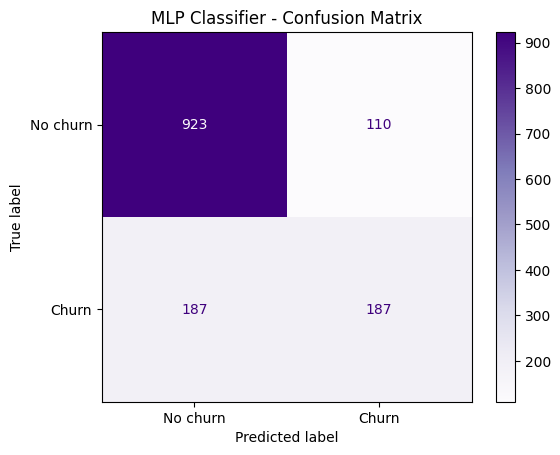

Optimal MLP threshold: 0.05
Minimum MLP cost: $7500.00


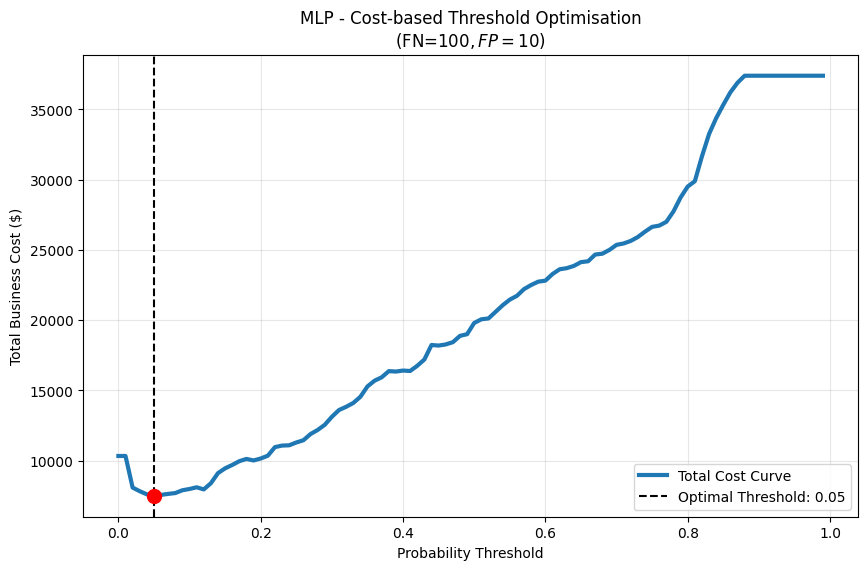

TN, FP, FN, TP: 413 620 13 361


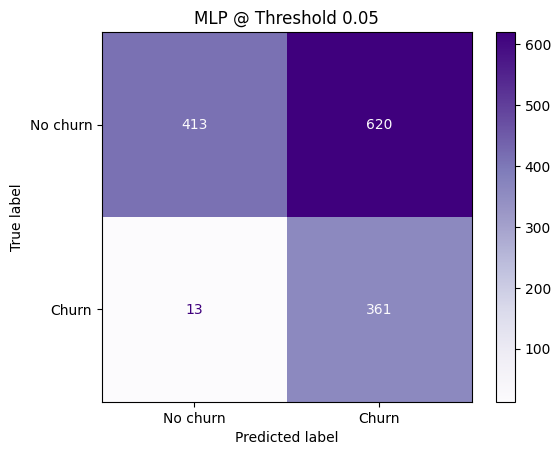

--- FINAL RESULTS (MLP) ---
Optimal Threshold: 0.05
Minimum Total Cost: $7500
Recall (Sensitivity): 0.97
Precision: 0.37
ROC-AUC: 0.8302

Confusion Matrix:
[[413 620]
 [ 13 361]]


In [ ]:
#=========================================================
#Multi-Layer Perceptron: More layers, adam solver, logistic activation function
#=========================================================
mlp_model = MLPClassifier(
    hidden_layer_sizes = (128, 64, 32),
    activation = "logistic",
    solver = "adam",
    learning_rate_init = 0.01,
    max_iter = 5000,
    early_stopping = True,
    n_iter_no_change = 20,
    random_state = 42
)
mlp_model.fit(X_train_scaled, y_train)

y_pred_mlp = mlp_model.predict(X_test_scaled)
y_prob_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]

print("======================================================= MLP Classifier =======================================================")
print(classification_report(y_test, y_pred_mlp, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_prob_mlp))

#================================================= Adding the confusion matrix ===============================================
#Predictions from the MLP
y_pred_mlp = mlp_model.predict(X_test_scaled)

#Raw confusion matrix
cm = confusion_matrix(y_test, y_pred_mlp)
print("Confusion Matrix:\n", cm)

#Heatmap
disp = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = ["No churn", "Churn"]
)

disp.plot(cmap = "Purples")
plt.title("MLP Classifier - Confusion Matrix")
plt.show()

#================================================= Threshold optimisation for the MLP ===============================================

#Getting predicted probabilities from tree
y_prob = y_prob_mlp

#Threshold optimisation
thresholds = np.arange(0.0, 1.0, 0.01)
costs = []

cost_fn = 100  # cost of missed churn
cost_fp = 10   # cost of wasted promo

for thresh in thresholds:
    y_pred_temp = (y_prob >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    costs.append(total_cost)

min_cost_index = np.argmin(costs)
optimal_threshold_mlp = thresholds[min_cost_index]
min_cost_mlp = costs[min_cost_index]

print(f"Optimal MLP threshold: {optimal_threshold_mlp:.2f}")
print(f"Minimum MLP cost: ${min_cost_mlp:.2f}")

#Plotting cost vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, linewidth=3, label="Total Cost Curve")
plt.axvline(optimal_threshold_mlp, color="black", linestyle="--",
            label=f'Optimal Threshold: {optimal_threshold_mlp:.2f}')
plt.scatter(optimal_threshold_mlp, min_cost_mlp, color="red", s=100, zorder=5)
plt.xlabel("Probability Threshold")
plt.ylabel("Total Business Cost ($)")
plt.title("MLP - Cost-based Threshold Optimisation\n(FN=$100, FP=$10)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#Applying the optimal threshold
y_pred_mlp_opt = (y_prob >= optimal_threshold_mlp).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_mlp_opt).ravel()
print("TN, FP, FN, TP:", tn, fp, fn, tp)

disp = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test, y_pred_mlp_opt),
    display_labels = ["No churn", "Churn"]
)
disp.plot(cmap="Purples")
plt.title(f"MLP @ Threshold {optimal_threshold_mlp:.2f}")
plt.show()

print(f"--- FINAL RESULTS (MLP) ---")
print(f"Optimal Threshold: {optimal_threshold_mlp:.2f}")
print(f"Minimum Total Cost: ${min_cost_mlp}")
print(f"Recall (Sensitivity): {recall_score(y_test, y_pred_mlp_opt):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_mlp_opt):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_mlp):.4f}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred_mlp_opt)}")

======================================================= MLP Classifier =======================================================
              precision    recall  f1-score   support

           0      0.808     0.816     0.812      1033
           1      0.478     0.465     0.472       374

    accuracy                          0.723      1407
   macro avg      0.643     0.641     0.642      1407
weighted avg      0.720     0.723     0.722      1407

ROC AUC: 0.732356306070787
Confusion Matrix:
 [[843 190]
 [200 174]]


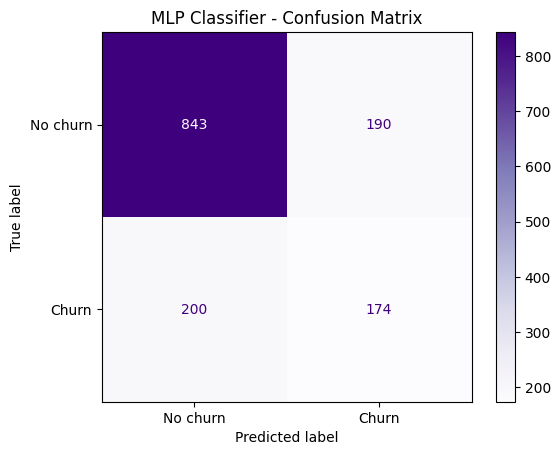

Optimal MLP threshold: 0.00
Minimum MLP cost: $10330.00


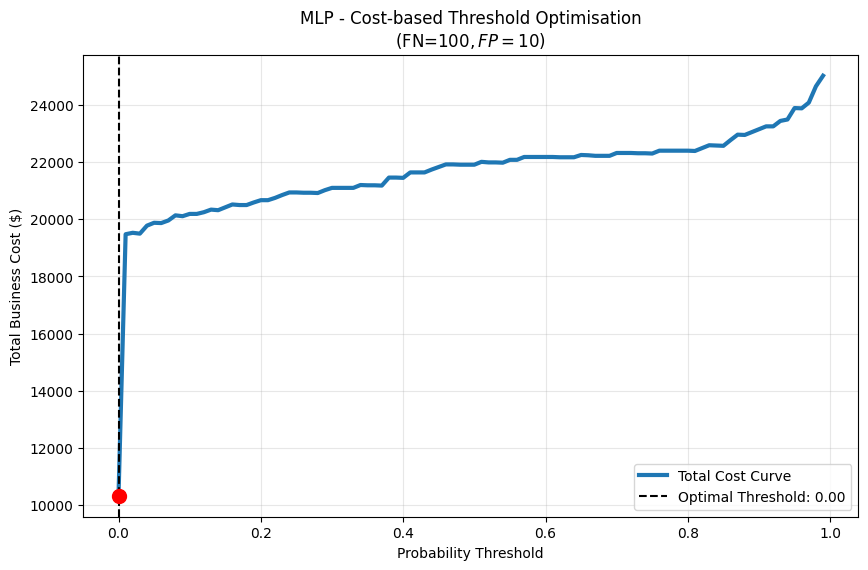

TN, FP, FN, TP: 0 1033 0 374


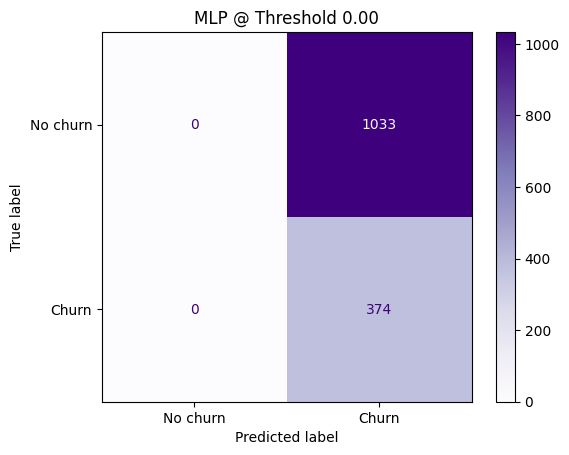

--- FINAL RESULTS (MLP) ---
Optimal Threshold: 0.00
Minimum Total Cost: $10330
Recall (Sensitivity): 1.00
Precision: 0.27
ROC-AUC: 0.7324

Confusion Matrix:
[[   0 1033]
 [   0  374]]


In [ ]:
#=========================================================
#Multi-Layer Perceptron: Fewer layers, lbfgs solver, relu activation
#=========================================================
mlp_model = MLPClassifier(
    hidden_layer_sizes = (100, 50),
    activation = "relu",
    solver = "lbfgs",
    learning_rate_init = 0.01,
    max_iter = 7500,
    early_stopping = True,
    n_iter_no_change = 20,
    random_state = 42
)
mlp_model.fit(X_train_scaled, y_train)

y_pred_mlp = mlp_model.predict(X_test_scaled)
y_prob_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]

print("======================================================= MLP Classifier =======================================================")
print(classification_report(y_test, y_pred_mlp, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_prob_mlp))

#================================================= Adding the confusion matrix ===============================================
#Predictions from the MLP
y_pred_mlp = mlp_model.predict(X_test_scaled)

#Raw confusion matrix
cm = confusion_matrix(y_test, y_pred_mlp)
print("Confusion Matrix:\n", cm)

#Heatmap
disp = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = ["No churn", "Churn"]
)

disp.plot(cmap = "Purples")
plt.title("MLP Classifier - Confusion Matrix")
plt.show()

#================================================= Threshold optimisation for the MLP ===============================================

#Getting predicted probabilities from tree
y_prob = y_prob_mlp

#Threshold optimisation
thresholds = np.arange(0.0, 1.0, 0.01)
costs = []

cost_fn = 100  # cost of missed churn
cost_fp = 10   # cost of wasted promo

for thresh in thresholds:
    y_pred_temp = (y_prob >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    costs.append(total_cost)

min_cost_index = np.argmin(costs)
optimal_threshold_mlp = thresholds[min_cost_index]
min_cost_mlp = costs[min_cost_index]

print(f"Optimal MLP threshold: {optimal_threshold_mlp:.2f}")
print(f"Minimum MLP cost: ${min_cost_mlp:.2f}")

#Plotting cost vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, linewidth=3, label="Total Cost Curve")
plt.axvline(optimal_threshold_mlp, color="black", linestyle="--",
            label=f'Optimal Threshold: {optimal_threshold_mlp:.2f}')
plt.scatter(optimal_threshold_mlp, min_cost_mlp, color="red", s=100, zorder=5)
plt.xlabel("Probability Threshold")
plt.ylabel("Total Business Cost ($)")
plt.title("MLP - Cost-based Threshold Optimisation\n(FN=$100, FP=$10)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#Applying the optimal threshold
y_pred_mlp_opt = (y_prob >= optimal_threshold_mlp).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_mlp_opt).ravel()
print("TN, FP, FN, TP:", tn, fp, fn, tp)

disp = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test, y_pred_mlp_opt),
    display_labels = ["No churn", "Churn"]
)
disp.plot(cmap="Purples")
plt.title(f"MLP @ Threshold {optimal_threshold_mlp:.2f}")
plt.show()

print(f"--- FINAL RESULTS (MLP) ---")
print(f"Optimal Threshold: {optimal_threshold_mlp:.2f}")
print(f"Minimum Total Cost: ${min_cost_mlp}")
print(f"Recall (Sensitivity): {recall_score(y_test, y_pred_mlp_opt):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_mlp_opt):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_mlp):.4f}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred_mlp_opt)}")

======================================================= MLP Classifier =======================================================
              precision    recall  f1-score   support

           0      0.828     0.903     0.864      1033
           1      0.643     0.481     0.550       374

    accuracy                          0.791      1407
   macro avg      0.735     0.692     0.707      1407
weighted avg      0.779     0.791     0.781      1407

ROC AUC: 0.8302074327927069
Confusion Matrix:
 [[933 100]
 [194 180]]


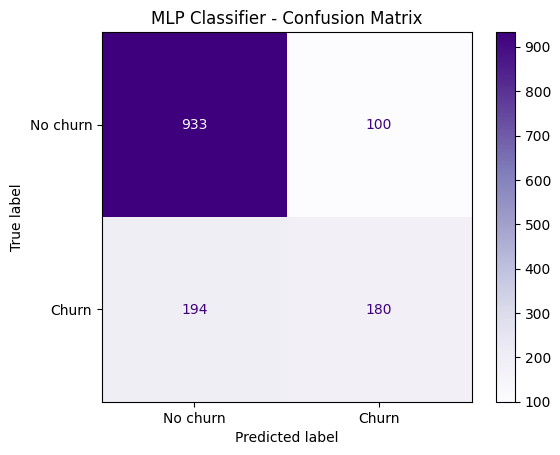

Optimal MLP threshold: 0.11
Minimum MLP cost: $7320.00


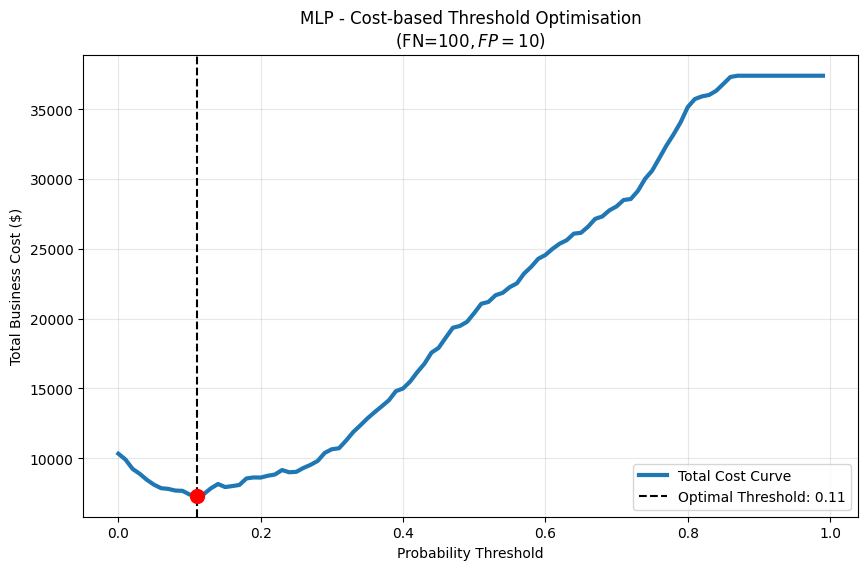

TN, FP, FN, TP: 441 592 14 360


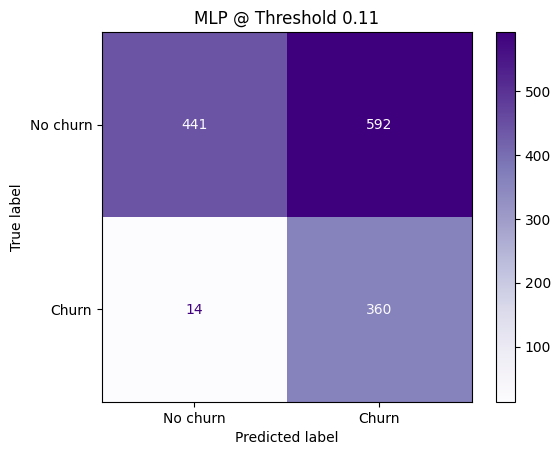

--- FINAL RESULTS (MLP) ---
Optimal Threshold: 0.11
Minimum Total Cost: $7320
Recall (Sensitivity): 0.96
Precision: 0.38
ROC-AUC: 0.8302

Confusion Matrix:
[[441 592]
 [ 14 360]]


In [ ]:
#=========================================================
#Multi-Layer Perceptron: More layers, adam solver, relu activation
#=========================================================
mlp_model = MLPClassifier(
    hidden_layer_sizes = (128, 64, 32),
    activation = "relu",
    solver = "adam",
    learning_rate_init = 0.01,
    max_iter = 5000,
    early_stopping = True,
    n_iter_no_change = 20,
    random_state = 42
)
mlp_model.fit(X_train_scaled, y_train)

y_pred_mlp = mlp_model.predict(X_test_scaled)
y_prob_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]

print("======================================================= MLP Classifier =======================================================")
print(classification_report(y_test, y_pred_mlp, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_prob_mlp))

#================================================= Adding the confusion matrix ===============================================
#Predictions from the MLP
y_pred_mlp = mlp_model.predict(X_test_scaled)

#Raw confusion matrix
cm = confusion_matrix(y_test, y_pred_mlp)
print("Confusion Matrix:\n", cm)

#Heatmap
disp = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = ["No churn", "Churn"]
)

disp.plot(cmap = "Purples")
plt.title("MLP Classifier - Confusion Matrix")
plt.show()

#================================================= Threshold optimisation for the MLP ===============================================

#Getting predicted probabilities from tree
y_prob = y_prob_mlp

#Threshold optimisation
thresholds = np.arange(0.0, 1.0, 0.01)
costs = []

cost_fn = 100  # cost of missed churn
cost_fp = 10   # cost of wasted promo

for thresh in thresholds:
    y_pred_temp = (y_prob >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    costs.append(total_cost)

min_cost_index = np.argmin(costs)
optimal_threshold_mlp = thresholds[min_cost_index]
min_cost_mlp = costs[min_cost_index]

print(f"Optimal MLP threshold: {optimal_threshold_mlp:.2f}")
print(f"Minimum MLP cost: ${min_cost_mlp:.2f}")

#Plotting cost vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, linewidth=3, label="Total Cost Curve")
plt.axvline(optimal_threshold_mlp, color="black", linestyle="--",
            label=f'Optimal Threshold: {optimal_threshold_mlp:.2f}')
plt.scatter(optimal_threshold_mlp, min_cost_mlp, color="red", s=100, zorder=5)
plt.xlabel("Probability Threshold")
plt.ylabel("Total Business Cost ($)")
plt.title("MLP - Cost-based Threshold Optimisation\n(FN=$100, FP=$10)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#Applying the optimal threshold
y_pred_mlp_opt = (y_prob >= optimal_threshold_mlp).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_mlp_opt).ravel()
print("TN, FP, FN, TP:", tn, fp, fn, tp)

disp = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test, y_pred_mlp_opt),
    display_labels = ["No churn", "Churn"]
)
disp.plot(cmap="Purples")
plt.title(f"MLP @ Threshold {optimal_threshold_mlp:.2f}")
plt.show()

print(f"--- FINAL RESULTS (MLP) ---")
print(f"Optimal Threshold: {optimal_threshold_mlp:.2f}")
print(f"Minimum Total Cost: ${min_cost_mlp}")
print(f"Recall (Sensitivity): {recall_score(y_test, y_pred_mlp_opt):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_mlp_opt):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_mlp):.4f}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred_mlp_opt)}")

======================================================= MLP Classifier =======================================================
              precision    recall  f1-score   support

           0      0.844     0.873     0.858      1033
           1      0.612     0.553     0.581       374

    accuracy                          0.788      1407
   macro avg      0.728     0.713     0.720      1407
weighted avg      0.782     0.788     0.785      1407

ROC AUC: 0.8309425327818358
Confusion Matrix:
 [[902 131]
 [167 207]]


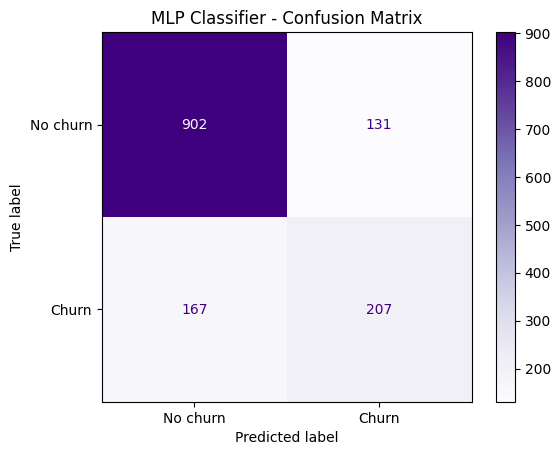

Optimal MLP threshold: 0.13
Minimum MLP cost: $7560.00


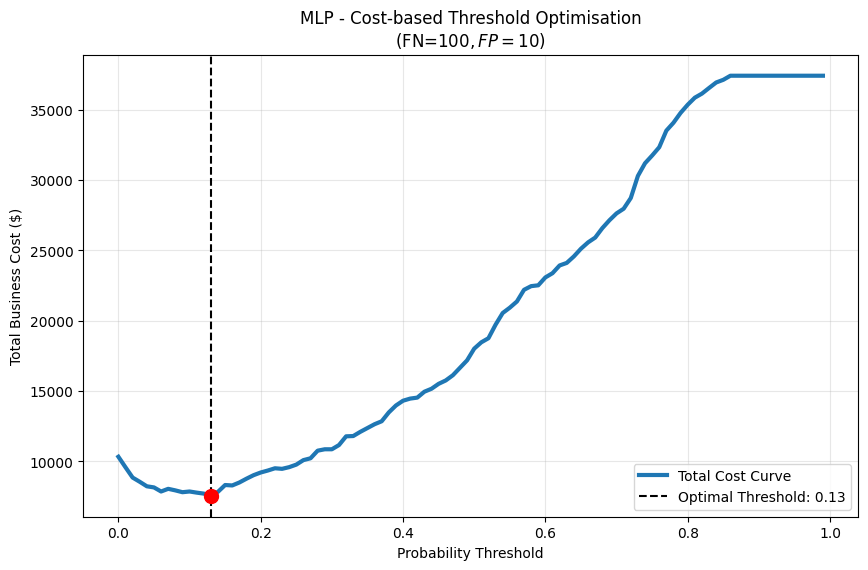

TN, FP, FN, TP: 547 486 27 347


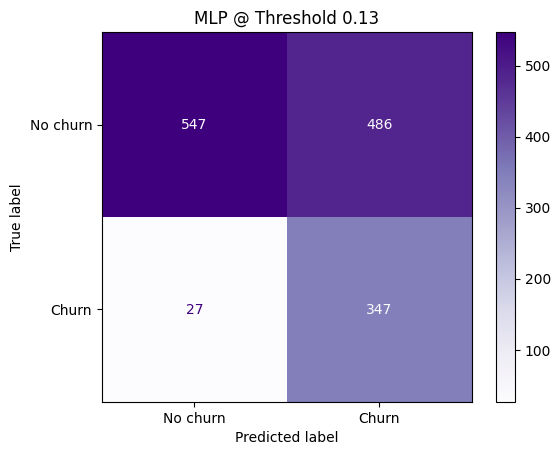

--- FINAL RESULTS (MLP) ---
Optimal Threshold: 0.13
Minimum Total Cost: $7560
Recall (Sensitivity): 0.93
Precision: 0.42
ROC-AUC: 0.8309

Confusion Matrix:
[[547 486]
 [ 27 347]]


In [ ]:
#=========================================================
#Multi-Layer Perceptron: More layers, sgd solver, relu activation
#=========================================================
mlp_model = MLPClassifier(
    hidden_layer_sizes = (128, 64, 32),
    activation = "relu",
    solver = "sgd",
    learning_rate_init = 0.01,
    max_iter = 5000,
    early_stopping = True,
    n_iter_no_change = 20,
    random_state = 42
)
mlp_model.fit(X_train_scaled, y_train)

y_pred_mlp = mlp_model.predict(X_test_scaled)
y_prob_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]

print("======================================================= MLP Classifier =======================================================")
print(classification_report(y_test, y_pred_mlp, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_prob_mlp))

#================================================= Adding the confusion matrix ===============================================
#Predictions from the MLP
y_pred_mlp = mlp_model.predict(X_test_scaled)

#Raw confusion matrix
cm = confusion_matrix(y_test, y_pred_mlp)
print("Confusion Matrix:\n", cm)

#Heatmap
disp = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = ["No churn", "Churn"]
)

disp.plot(cmap = "Purples")
plt.title("MLP Classifier - Confusion Matrix")
plt.show()

#================================================= Threshold optimisation for the MLP ===============================================

#Getting predicted probabilities from tree
y_prob = y_prob_mlp

#Threshold optimisation
thresholds = np.arange(0.0, 1.0, 0.01)
costs = []

cost_fn = 100  # cost of missed churn
cost_fp = 10   # cost of wasted promo

for thresh in thresholds:
    y_pred_temp = (y_prob >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    costs.append(total_cost)

min_cost_index = np.argmin(costs)
optimal_threshold_mlp = thresholds[min_cost_index]
min_cost_mlp = costs[min_cost_index]

print(f"Optimal MLP threshold: {optimal_threshold_mlp:.2f}")
print(f"Minimum MLP cost: ${min_cost_mlp:.2f}")

#Plotting cost vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, linewidth=3, label="Total Cost Curve")
plt.axvline(optimal_threshold_mlp, color="black", linestyle="--",
            label=f'Optimal Threshold: {optimal_threshold_mlp:.2f}')
plt.scatter(optimal_threshold_mlp, min_cost_mlp, color="red", s=100, zorder=5)
plt.xlabel("Probability Threshold")
plt.ylabel("Total Business Cost ($)")
plt.title("MLP - Cost-based Threshold Optimisation\n(FN=$100, FP=$10)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#Applying the optimal threshold
y_pred_mlp_opt = (y_prob >= optimal_threshold_mlp).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_mlp_opt).ravel()
print("TN, FP, FN, TP:", tn, fp, fn, tp)

disp = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test, y_pred_mlp_opt),
    display_labels = ["No churn", "Churn"]
)
disp.plot(cmap="Purples")
plt.title(f"MLP @ Threshold {optimal_threshold_mlp:.2f}")
plt.show()

print(f"--- FINAL RESULTS (MLP) ---")
print(f"Optimal Threshold: {optimal_threshold_mlp:.2f}")
print(f"Minimum Total Cost: ${min_cost_mlp}")
print(f"Recall (Sensitivity): {recall_score(y_test, y_pred_mlp_opt):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_mlp_opt):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_mlp):.4f}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred_mlp_opt)}")

======================================================= MLP Classifier =======================================================
              precision    recall  f1-score   support

           0      0.834     0.888     0.860      1033
           1      0.623     0.513     0.563       374

    accuracy                          0.788      1407
   macro avg      0.729     0.701     0.712      1407
weighted avg      0.778     0.788     0.781      1407

ROC AUC: 0.8320840084691801
Confusion Matrix:
 [[917 116]
 [182 192]]


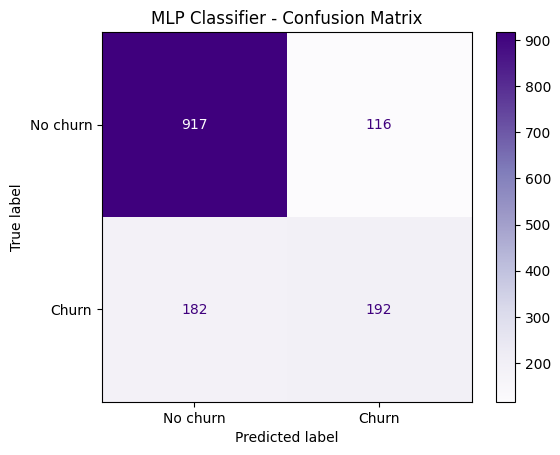

Optimal MLP threshold: 0.10
Minimum MLP cost: $7680.00


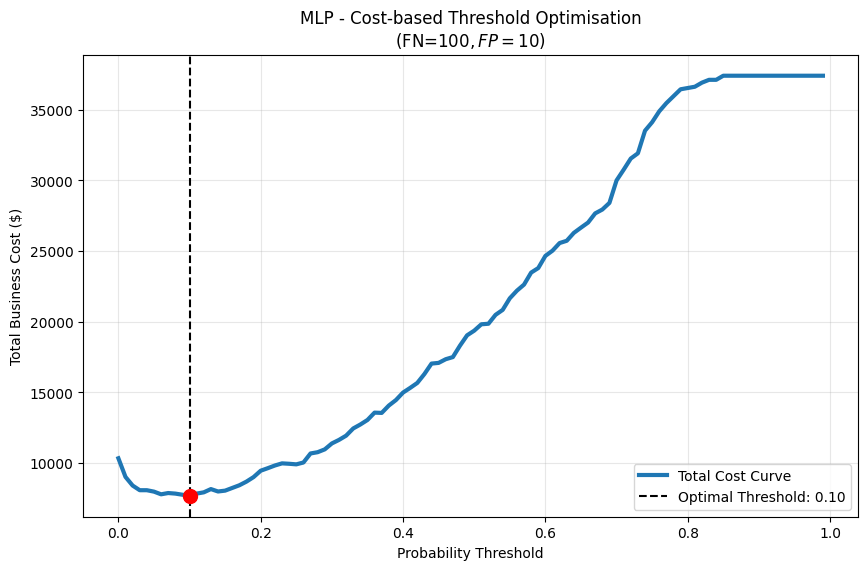

TN, FP, FN, TP: 505 528 24 350


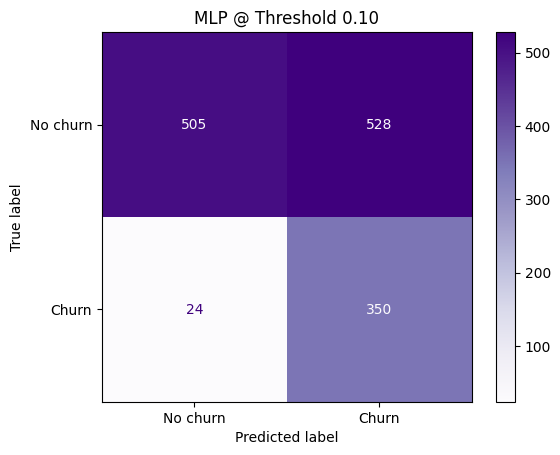

--- FINAL RESULTS (MLP) ---
Optimal Threshold: 0.10
Minimum Total Cost: $7680
Recall (Sensitivity): 0.94
Precision: 0.40
ROC-AUC: 0.8321

Confusion Matrix:
[[505 528]
 [ 24 350]]


In [ ]:
#=========================================================
#Multi-Layer Perceptron: More layers, sgd solver, tanh activation
#=========================================================
mlp_model = MLPClassifier(
    hidden_layer_sizes = (128, 64, 32),
    activation = "identity",
    solver = "lbfgs",
    learning_rate_init = 0.01,
    max_iter = 5000,
    early_stopping = True,
    n_iter_no_change = 20,
    random_state = 42
)
mlp_model.fit(X_train_scaled, y_train)

y_pred_mlp = mlp_model.predict(X_test_scaled)
y_prob_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]

print("======================================================= MLP Classifier =======================================================")
print(classification_report(y_test, y_pred_mlp, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_prob_mlp))

#================================================= Adding the confusion matrix ===============================================
#Predictions from the MLP
y_pred_mlp = mlp_model.predict(X_test_scaled)

#Raw confusion matrix
cm = confusion_matrix(y_test, y_pred_mlp)
print("Confusion Matrix:\n", cm)

#Heatmap
disp = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = ["No churn", "Churn"]
)

disp.plot(cmap = "Purples")
plt.title("MLP Classifier - Confusion Matrix")
plt.show()

#================================================= Threshold optimisation for the MLP ===============================================

#Getting predicted probabilities from tree
y_prob = y_prob_mlp

#Threshold optimisation
thresholds = np.arange(0.0, 1.0, 0.01)
costs = []

cost_fn = 100  # cost of missed churn
cost_fp = 10   # cost of wasted promo

for thresh in thresholds:
    y_pred_temp = (y_prob >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    costs.append(total_cost)

min_cost_index = np.argmin(costs)
optimal_threshold_mlp = thresholds[min_cost_index]
min_cost_mlp = costs[min_cost_index]

print(f"Optimal MLP threshold: {optimal_threshold_mlp:.2f}")
print(f"Minimum MLP cost: ${min_cost_mlp:.2f}")

#Plotting cost vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, linewidth=3, label="Total Cost Curve")
plt.axvline(optimal_threshold_mlp, color="black", linestyle="--",
            label=f'Optimal Threshold: {optimal_threshold_mlp:.2f}')
plt.scatter(optimal_threshold_mlp, min_cost_mlp, color="red", s=100, zorder=5)
plt.xlabel("Probability Threshold")
plt.ylabel("Total Business Cost ($)")
plt.title("MLP - Cost-based Threshold Optimisation\n(FN=$100, FP=$10)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#Applying the optimal threshold
y_pred_mlp_opt = (y_prob >= optimal_threshold_mlp).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_mlp_opt).ravel()
print("TN, FP, FN, TP:", tn, fp, fn, tp)

disp = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test, y_pred_mlp_opt),
    display_labels = ["No churn", "Churn"]
)
disp.plot(cmap="Purples")
plt.title(f"MLP @ Threshold {optimal_threshold_mlp:.2f}")
plt.show()

print(f"--- FINAL RESULTS (MLP) ---")
print(f"Optimal Threshold: {optimal_threshold_mlp:.2f}")
print(f"Minimum Total Cost: ${min_cost_mlp}")
print(f"Recall (Sensitivity): {recall_score(y_test, y_pred_mlp_opt):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_mlp_opt):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_mlp):.4f}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred_mlp_opt)}")

c:\users\rahul\appdata\local\programs\python\python39\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


======================================================= MLP Classifier =======================================================
              precision    recall  f1-score   support

           0      0.801     0.820     0.811      1033
           1      0.469     0.439     0.453       374

    accuracy                          0.719      1407
   macro avg      0.635     0.629     0.632      1407
weighted avg      0.713     0.719     0.716      1407

ROC AUC: 0.6994968188806808
Confusion Matrix:
 [[847 186]
 [210 164]]


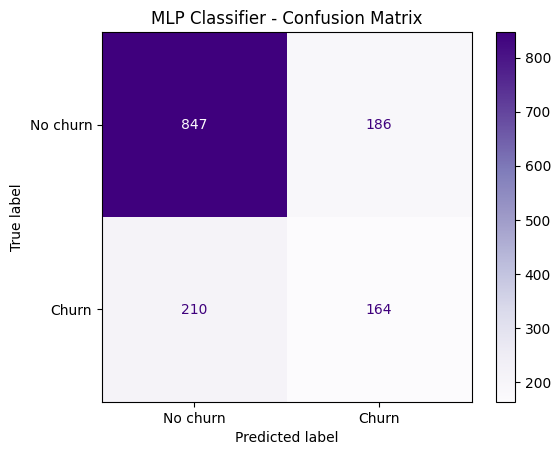

Optimal MLP threshold: 0.00
Minimum MLP cost: $10330.00


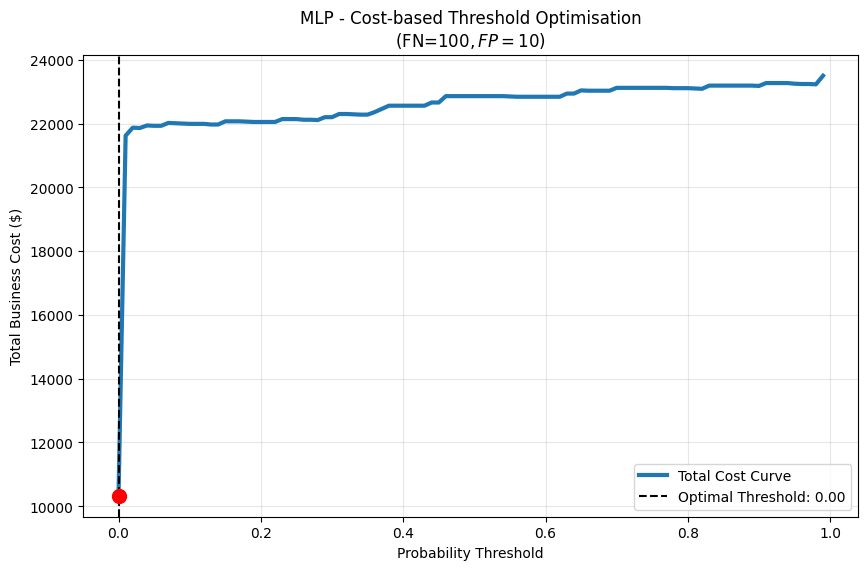

TN, FP, FN, TP: 0 1033 0 374


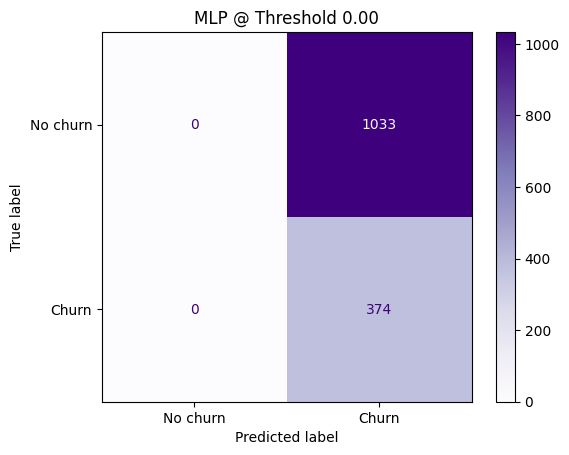

--- FINAL RESULTS (MLP) ---
Optimal Threshold: 0.00
Minimum Total Cost: $10330
Recall (Sensitivity): 1.00
Precision: 0.27
ROC-AUC: 0.6995

Confusion Matrix:
[[   0 1033]
 [   0  374]]


In [ ]:
#=========================================================
#Multi-Layer Perceptron: Fewer layers, lbfgs solver, logistic activation function
#=========================================================
mlp_model = MLPClassifier(
    hidden_layer_sizes = (100, 50),
    activation = "logistic",
    solver = "lbfgs",
    learning_rate_init = 0.01,
    max_iter = 5000,
    early_stopping = True,
    n_iter_no_change = 20,
    random_state = 42
)
mlp_model.fit(X_train_scaled, y_train)

y_pred_mlp = mlp_model.predict(X_test_scaled)
y_prob_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]

print("======================================================= MLP Classifier =======================================================")
print(classification_report(y_test, y_pred_mlp, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_prob_mlp))

#================================================= Adding the confusion matrix ===============================================
#Predictions from the MLP
y_pred_mlp = mlp_model.predict(X_test_scaled)

#Raw confusion matrix
cm = confusion_matrix(y_test, y_pred_mlp)
print("Confusion Matrix:\n", cm)

#Heatmap
disp = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = ["No churn", "Churn"]
)

disp.plot(cmap = "Purples")
plt.title("MLP Classifier - Confusion Matrix")
plt.show()

#================================================= Threshold optimisation for the MLP ===============================================

#Getting predicted probabilities from tree
y_prob = y_prob_mlp

#Threshold optimisation
thresholds = np.arange(0.0, 1.0, 0.01)
costs = []

cost_fn = 100  # cost of missed churn
cost_fp = 10   # cost of wasted promo

for thresh in thresholds:
    y_pred_temp = (y_prob >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    costs.append(total_cost)

min_cost_index = np.argmin(costs)
optimal_threshold_mlp = thresholds[min_cost_index]
min_cost_mlp = costs[min_cost_index]

print(f"Optimal MLP threshold: {optimal_threshold_mlp:.2f}")
print(f"Minimum MLP cost: ${min_cost_mlp:.2f}")

#Plotting cost vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, linewidth=3, label="Total Cost Curve")
plt.axvline(optimal_threshold_mlp, color="black", linestyle="--",
            label=f'Optimal Threshold: {optimal_threshold_mlp:.2f}')
plt.scatter(optimal_threshold_mlp, min_cost_mlp, color="red", s=100, zorder=5)
plt.xlabel("Probability Threshold")
plt.ylabel("Total Business Cost ($)")
plt.title("MLP - Cost-based Threshold Optimisation\n(FN=$100, FP=$10)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#Applying the optimal threshold
y_pred_mlp_opt = (y_prob >= optimal_threshold_mlp).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_mlp_opt).ravel()
print("TN, FP, FN, TP:", tn, fp, fn, tp)

disp = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test, y_pred_mlp_opt),
    display_labels = ["No churn", "Churn"]
)
disp.plot(cmap="Purples")
plt.title(f"MLP @ Threshold {optimal_threshold_mlp:.2f}")
plt.show()

print(f"--- FINAL RESULTS (MLP) ---")
print(f"Optimal Threshold: {optimal_threshold_mlp:.2f}")
print(f"Minimum Total Cost: ${min_cost_mlp}")
print(f"Recall (Sensitivity): {recall_score(y_test, y_pred_mlp_opt):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_mlp_opt):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_mlp):.4f}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred_mlp_opt)}")

======================================================= MLP Classifier =======================================================
              precision    recall  f1-score   support

           0      0.826     0.898     0.860      1033
           1      0.629     0.476     0.542       374

    accuracy                          0.786      1407
   macro avg      0.727     0.687     0.701      1407
weighted avg      0.773     0.786     0.776      1407

ROC AUC: 0.8061717338523899
Confusion Matrix:
 [[928 105]
 [196 178]]


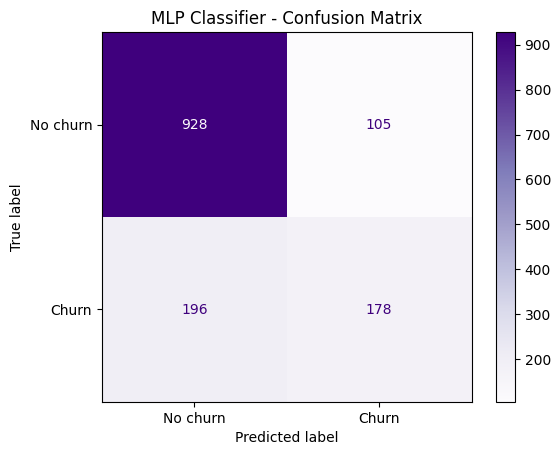

Optimal MLP threshold: 0.03
Minimum MLP cost: $8260.00


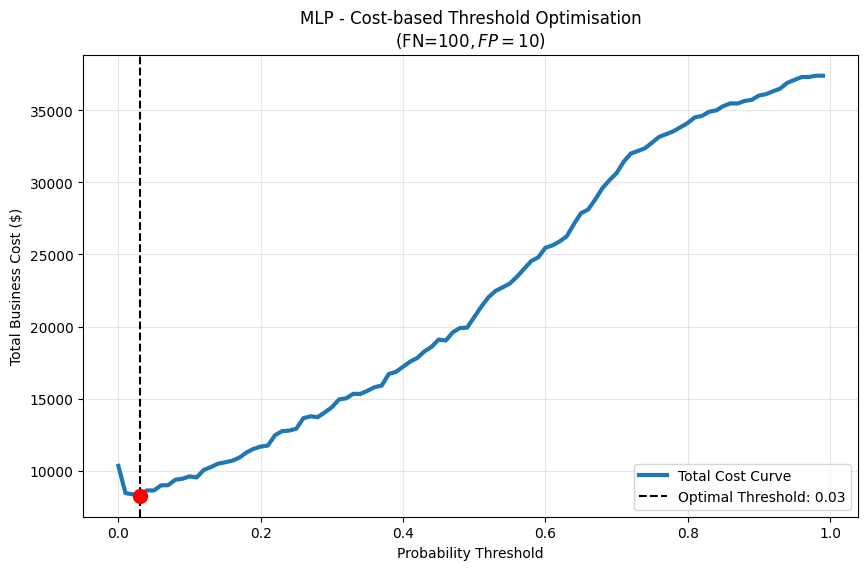

TN, FP, FN, TP: 407 626 20 354


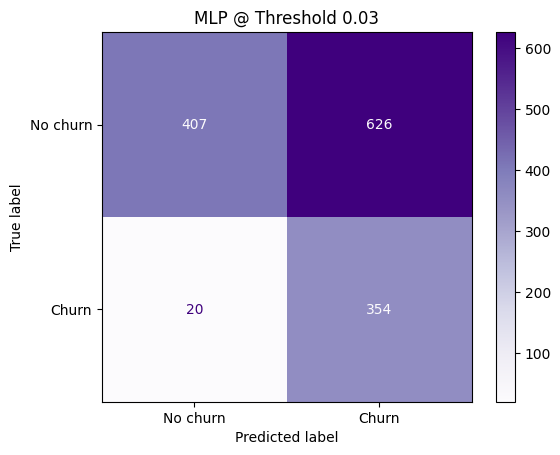

--- FINAL RESULTS (MLP) ---
Optimal Threshold: 0.03
Minimum Total Cost: $8260
Recall (Sensitivity): 0.95
Precision: 0.36
ROC-AUC: 0.8062

Confusion Matrix:
[[407 626]
 [ 20 354]]


In [ ]:
#=========================================================
#Multi-Layer Perceptron: Fewer layers, adam solver
#=========================================================
mlp_model = MLPClassifier(
    hidden_layer_sizes = (100, 50),
    activation = "relu",
    solver = "adam",
    learning_rate_init = 0.01,
    max_iter = 5000,
    early_stopping = True,
    n_iter_no_change = 20,
    random_state = 42
)
mlp_model.fit(X_train_scaled, y_train)

y_pred_mlp = mlp_model.predict(X_test_scaled)
y_prob_mlp = mlp_model.predict_proba(X_test_scaled)[:, 1]

print("======================================================= MLP Classifier =======================================================")
print(classification_report(y_test, y_pred_mlp, digits=3))
print("ROC AUC:", roc_auc_score(y_test, y_prob_mlp))

#================================================= Adding the confusion matrix ===============================================
#Predictions from the MLP
y_pred_mlp = mlp_model.predict(X_test_scaled)

#Raw confusion matrix
cm = confusion_matrix(y_test, y_pred_mlp)
print("Confusion Matrix:\n", cm)

#Heatmap
disp = ConfusionMatrixDisplay(
    confusion_matrix = cm,
    display_labels = ["No churn", "Churn"]
)

disp.plot(cmap = "Purples")
plt.title("MLP Classifier - Confusion Matrix")
plt.show()

#================================================= Threshold optimisation for the MLP ===============================================

#Getting predicted probabilities from tree
y_prob = y_prob_mlp

#Threshold optimisation
thresholds = np.arange(0.0, 1.0, 0.01)
costs = []

cost_fn = 100  # cost of missed churn
cost_fp = 10   # cost of wasted promo

for thresh in thresholds:
    y_pred_temp = (y_prob >= thresh).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    costs.append(total_cost)

min_cost_index = np.argmin(costs)
optimal_threshold_mlp = thresholds[min_cost_index]
min_cost_mlp = costs[min_cost_index]

print(f"Optimal MLP threshold: {optimal_threshold_mlp:.2f}")
print(f"Minimum MLP cost: ${min_cost_mlp:.2f}")

#Plotting cost vs threshold
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, linewidth=3, label="Total Cost Curve")
plt.axvline(optimal_threshold_mlp, color="black", linestyle="--",
            label=f'Optimal Threshold: {optimal_threshold_mlp:.2f}')
plt.scatter(optimal_threshold_mlp, min_cost_mlp, color="red", s=100, zorder=5)
plt.xlabel("Probability Threshold")
plt.ylabel("Total Business Cost ($)")
plt.title("MLP - Cost-based Threshold Optimisation\n(FN=$100, FP=$10)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#Applying the optimal threshold
y_pred_mlp_opt = (y_prob >= optimal_threshold_mlp).astype(int)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_mlp_opt).ravel()
print("TN, FP, FN, TP:", tn, fp, fn, tp)

disp = ConfusionMatrixDisplay(
    confusion_matrix = confusion_matrix(y_test, y_pred_mlp_opt),
    display_labels = ["No churn", "Churn"]
)
disp.plot(cmap="Purples")
plt.title(f"MLP @ Threshold {optimal_threshold_mlp:.2f}")
plt.show()

print(f"--- FINAL RESULTS (MLP) ---")
print(f"Optimal Threshold: {optimal_threshold_mlp:.2f}")
print(f"Minimum Total Cost: ${min_cost_mlp}")
print(f"Recall (Sensitivity): {recall_score(y_test, y_pred_mlp_opt):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_mlp_opt):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob_mlp):.4f}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred_mlp_opt)}")

### XGBoost

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_curve, roc_auc_score, classification_report
import random

In [ ]:
# Load data
df = pd.read_csv('Cleaned_Dataset.csv')
df.TotalCharges = df.TotalCharges.astype(float)
df = df.drop('customerID', axis = 1)

# Split Data
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [ ]:
# ==========================================
#  Blackbox Models: Surrogate vs L2 Loss
# ==========================================
# We use Classifiers for Surrogate (Gini/LogLoss) and Regressors for L2 (Mean Squared Error)

models = {
    'RF_Surrogate': RandomForestClassifier(n_estimators=100, random_state=42),
    'RF_L2': RandomForestRegressor(n_estimators=100, random_state=42),

    'ExtraTrees_Surrogate': ExtraTreesClassifier(n_estimators=100, random_state=42),
    'ExtraTrees_L2': ExtraTreesRegressor(n_estimators=100, random_state=42),

    'GradBoost_Surrogate': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'GradBoost_L2': GradientBoostingRegressor(n_estimators=100, random_state=42)
}

Training and evaluating models...


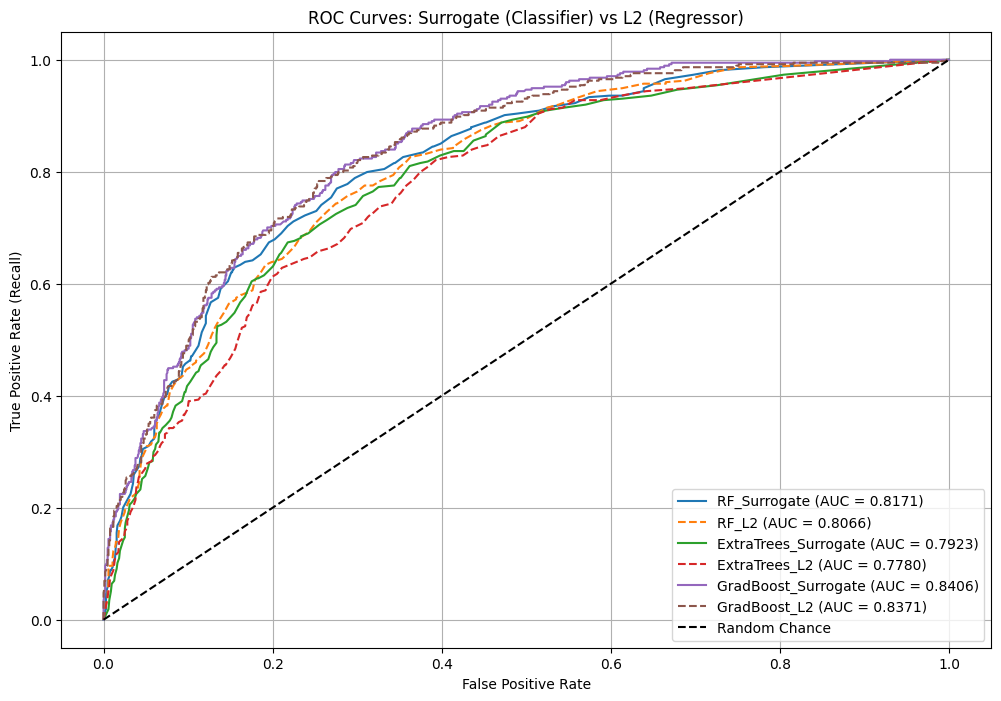


--- Leaderboard (Validation AUC) ---
GradBoost_Surrogate: 0.8406
GradBoost_L2: 0.8371
RF_Surrogate: 0.8171
RF_L2: 0.8066
ExtraTrees_Surrogate: 0.7923
ExtraTrees_L2: 0.7780


In [ ]:
# ==========================================
#  Training & Comparison
# ==========================================
random.seed(42)
results = {}
plt.figure(figsize=(12, 8))

print("Training and evaluating models...")

for name, model in models.items():
    # Fit
    model.fit(X_train_scaled, y_train)

    # Predict
    # For Classifiers, we need the probability of the positive class (1)
    # For Regressors, the output IS the score (between 0 and 1 usually)
    if 'Classifier' in str(type(model)):
        y_pred_score = model.predict_proba(X_test_scaled)[:, 1]
    else:
        y_pred_score = model.predict(X_test_scaled)

    # Calculate AUC
    auc_val = roc_auc_score(y_test, y_pred_score)
    results[name] = auc_val

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_test, y_pred_score)
    # Style: Solid line for Surrogate, Dashed for L2 to make visual comparison easier
    linestyle = '-' if 'Surrogate' in name else '--'
    plt.plot(fpr, tpr, linestyle=linestyle, label=f'{name} (AUC = {auc_val:.4f})')

# Plot formatting
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('ROC Curves: Surrogate (Classifier) vs L2 (Regressor)')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('ROC_Curves.png')
plt.show()

# Print sorted results
print("\n--- Leaderboard (Validation AUC) ---")
for name, score in sorted(results.items(), key=lambda x: x[1], reverse=True):
    print(f"{name}: {score:.4f}")

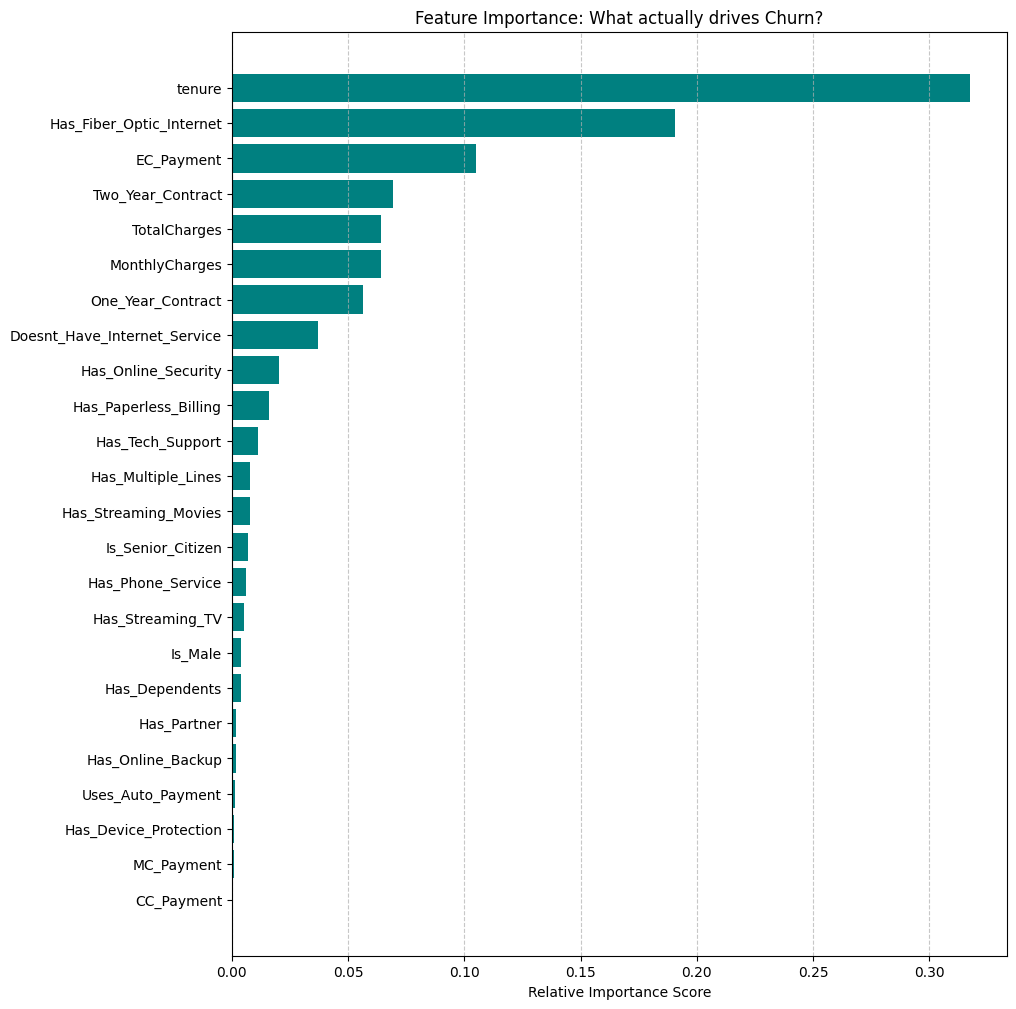

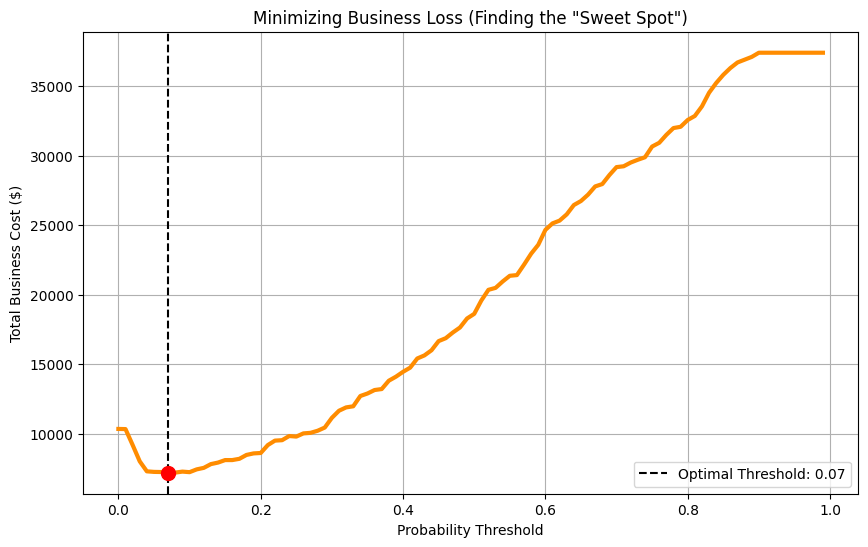

--- RESULTS ---
Optimal Threshold: 0.07
Minimum Cost: $7180

metrics at this threshold:
Recall (Sensitivity): 0.97 (We catch 97% of churners)
Precision: 0.38 (But only 38% of flagged people actually churn)

Confusion Matrix:
[[435 598]
 [ 12 362]]


In [ ]:
# ==========================================
#  Feature Importance & Threshold Optimization
# ==========================================
random.seed(42)
from sklearn.metrics import confusion_matrix, recall_score, precision_score

# 1. Retrieve the Winner (Gradient Boosting Surrogate)
gb_model = models['GradBoost_Surrogate']

# 2. Feature Importance Check
feature_importance = gb_model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10, 12))
plt.barh(pos, feature_importance[sorted_idx], align='center', color='teal')
plt.yticks(pos, np.array(X_train.columns)[sorted_idx])
plt.xlabel('Relative Importance Score')
plt.title('Feature Importance: What actually drives Churn?')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.savefig('Feature_Importance.png')
plt.show()

# 3. Threshold Optimization (The "Money" Step)
# Scenario:
# Cost of False Negative (Missed Churn) = $100 (Estimated LTV lost + Acquisition Cost)
# Cost of False Positive (Wasted Promo) = $10 (Cost of retention campaign)
# Goal: Minimize TOTAL COST. Have to add literature to back up this claim....

# Get probabilities for Class 1 (Churn)
y_pred_prob = gb_model.predict_proba(X_test_scaled)[:, 1]

thresholds = np.arange(0.0, 1.0, 0.01)
costs = []

cost_fn = 100
cost_fp = 10

for thresh in thresholds:
    # Convert probabilities to 0/1 predictions based on current threshold
    y_pred_temp = (y_pred_prob >= thresh).astype(int)

    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()

    # Calculate total business cost
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    costs.append(total_cost)

# Find the minimum cost
min_cost_index = np.argmin(costs)
optimal_threshold = thresholds[min_cost_index]
min_cost = costs[min_cost_index]

# Plot Cost Curve
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, linewidth=3, color='darkorange')
plt.axvline(optimal_threshold, color='black', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.scatter(optimal_threshold, min_cost, color='red', s=100, zorder=5)
plt.xlabel('Probability Threshold')
plt.ylabel('Total Business Cost ($)')
plt.title('Minimizing Business Loss (Finding the "Sweet Spot")')
plt.legend()
plt.grid(True)
plt.savefig('normal_threshold_optimization.png')
plt.show()

# 4. Final Evaluation at Optimal Threshold
y_pred_optimal = (y_pred_prob >= optimal_threshold).astype(int)

print(f"--- RESULTS ---")
print(f"Optimal Threshold: {optimal_threshold}")
print(f"Minimum Cost: ${min_cost}")
print(f"\nmetrics at this threshold:")
print(f"Recall (Sensitivity): {recall_score(y_test, y_pred_optimal):.2f} (We catch {recall_score(y_test, y_pred_optimal)*100:.0f}% of churners)")
print(f"Precision: {precision_score(y_test, y_pred_optimal):.2f} (But only {precision_score(y_test, y_pred_optimal)*100:.0f}% of flagged people actually churn)")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred_optimal)}")

In [ ]:
# ==========================================
#  Hyperparameter Optimization (Gradient Boosting)
# ==========================================
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score, confusion_matrix

# Initialize the classifier
gb_clf = GradientBoostingClassifier(random_state=42)

# Define the parameter grid
# We focus on the most impactful parameters: n_estimators (number of trees),
# learning_rate (step size), and max_depth (complexity of each tree).
param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

print("Starting Grid Search... this may take a minute.")
grid_search = GridSearchCV(
    estimator=gb_clf,
    param_grid=param_grid,
    cv=3,                 # 3-fold Cross Validation
    scoring='roc_auc',    # Optimize for Area Under Curve
    n_jobs=-1,            # Use all available cores
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_gb_model = grid_search.best_estimator_

print("\nBest Parameters found:", grid_search.best_params_)
print(f"Best CV ROC-AUC: {grid_search.best_score_:.4f}")

Starting Grid Search... this may take a minute.
Fitting 3 folds for each of 18 candidates, totalling 54 fits

Best Parameters found: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}
Best CV ROC-AUC: 0.8471


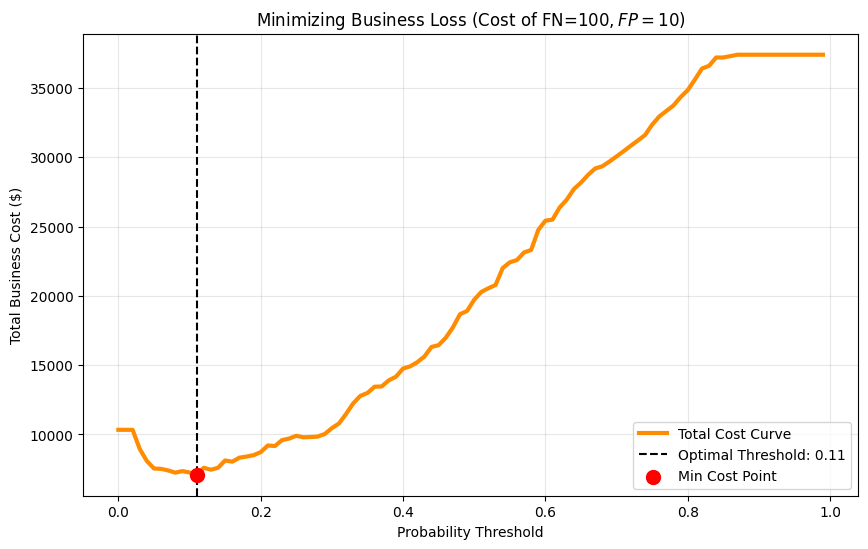

In [ ]:
# ==========================================
#  Threshold Optimization (Minimizing Business Cost)
# ==========================================
# Same as before -
# Cost of False Negative (Missed Churn) = $100
# Cost of False Positive (Wasted Promo) = $10
random.seed(42)

y_prob = best_gb_model.predict_proba(X_test_scaled)[:, 1]

thresholds = np.arange(0.0, 1.0, 0.01)
costs = []

cost_fn = 100
cost_fp = 10

for thresh in thresholds:
    # Convert probabilities to 0/1 predictions
    y_pred_temp = (y_prob >= thresh).astype(int)

    # Calculate confusion matrix components
    # (Note: we use .ravel() to extract True Neg, False Pos, False Neg, True Pos)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred_temp).ravel()

    # Calculate total business cost for this threshold
    total_cost = (fn * cost_fn) + (fp * cost_fp)
    costs.append(total_cost)

# Find the threshold that gives the minimum cost
min_cost_index = np.argmin(costs)
optimal_threshold = thresholds[min_cost_index]
min_cost = costs[min_cost_index]

# --- Visualization ---
plt.figure(figsize=(10, 6))
plt.plot(thresholds, costs, linewidth=3, color='darkorange', label='Total Cost Curve')
plt.axvline(optimal_threshold, color='black', linestyle='--', label=f'Optimal Threshold: {optimal_threshold:.2f}')
plt.scatter(optimal_threshold, min_cost, color='red', s=100, zorder=5, label='Min Cost Point')

plt.xlabel('Probability Threshold')
plt.ylabel('Total Business Cost ($)')
plt.title('Minimizing Business Loss (Cost of FN=$100, FP=$10)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('optimized_threshold_optimization.png')
plt.show()

In [ ]:
# ==========================================
# Final Results at Optimal Threshold
# ==========================================
y_pred_optimal = (y_prob >= optimal_threshold).astype(int)

print(f"--- RESULTS ---")
print(f"Optimal Threshold: {optimal_threshold:.2f}")
print(f"Minimum Total Cost: ${min_cost}")
print(f"\nMetrics at this threshold:")
print(f"Recall (Sensitivity): {recall_score(y_test, y_pred_optimal):.2f}")
print(f"Precision: {precision_score(y_test, y_pred_optimal):.2f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_prob):.4f}")
print(f"\nConfusion Matrix:\n{confusion_matrix(y_test, y_pred_optimal)}")

--- RESULTS ---
Optimal Threshold: 0.11
Minimum Total Cost: $7090

Metrics at this threshold:
Recall (Sensitivity): 0.95
Precision: 0.40
ROC-AUC: 0.8416

Confusion Matrix:
[[504 529]
 [ 18 356]]


In [ ]:
# ==========================================
# Maximizing Recall vs Maximizing F1 score (treats fn and fp as same) vs Cost
# ==========================================
# We will compare three strategies to see which one actually saves the most money.
random.seed(42)
# Define Costs
COST_FN = 100  # Losing a customer
COST_FP = 10   # Cost of retention offer

y_prob = best_gb_model.predict_proba(X_test_scaled)[:, 1]
thresholds = np.arange(0.01, 1.0, 0.01)

# Store results
results_df = pd.DataFrame(columns=['Threshold', 'Recall', 'Precision', 'F1_Score', 'Total_Cost'])

for t in thresholds:
    preds = (y_prob >= t).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

    recall = recall_score(y_test, preds, zero_division=0)
    precision = precision_score(y_test, preds, zero_division=0)
    f1 = f1_score(y_test, preds, zero_division=0)
    cost = (fn * COST_FN) + (fp * COST_FP)

    # Use loc to append row
    results_df.loc[len(results_df)] = [t, recall, precision, f1, cost]

# Strategy 1: Maximize Recall (Sensitivity)
# We pick the highest threshold that still gives us ~99% recall (to avoid the trivial 0.0 threshold)
# or just pick the max recall available.
strat_recall = results_df.sort_values(by='Recall', ascending=False).iloc[0]

# Strategy 2: Maximize F1 Score
strat_f1 = results_df.sort_values(by='F1_Score', ascending=False).iloc[0]

# Strategy 3: Minimize Business Cost
strat_cost = results_df.sort_values(by='Total_Cost', ascending=True).iloc[0]

# --- Print Comparison Table ---
print(f"{'STRATEGY':<25} | {'THRESH':<6} | {'RECALL':<6} | {'PRECISION':<9} | {'F1':<6} | {'TOTAL COST ($)':<12}")
print("-" * 85)
print(f"{'Max Recall (Catch All)':<25} | {strat_recall['Threshold']:.2f}   | {strat_recall['Recall']:.2f}   | {strat_recall['Precision']:.2f}      | {strat_recall['F1_Score']:.2f}   | ${strat_recall['Total_Cost']:,.0f}")
print(f"{'Max F1 (Balanced)':<25} | {strat_f1['Threshold']:.2f}   | {strat_f1['Recall']:.2f}   | {strat_f1['Precision']:.2f}      | {strat_f1['F1_Score']:.2f}   | ${strat_f1['Total_Cost']:,.0f}")
print(f"{'Min Business Cost':<25} | {strat_cost['Threshold']:.2f}   | {strat_cost['Recall']:.2f}   | {strat_cost['Precision']:.2f}      | {strat_cost['F1_Score']:.2f}   | ${strat_cost['Total_Cost']:,.0f}")
print("-" * 85)

print("\nCONCLUSION:")
if strat_cost['Total_Cost'] < strat_f1['Total_Cost']:
    print(f"Minimizing Cost saves you ${strat_f1['Total_Cost'] - strat_cost['Total_Cost']:,.0f} compared to F1 Score.")
else:
    print("F1 Score and Cost Minimization yielded similar results.")

if strat_cost['Total_Cost'] < strat_recall['Total_Cost']:
    print(f"Minimizing Cost saves you ${strat_recall['Total_Cost'] - strat_cost['Total_Cost']:,.0f} compared to Maximizing Recall.")

STRATEGY                  | THRESH | RECALL | PRECISION | F1     | TOTAL COST ($)
-------------------------------------------------------------------------------------
Max Recall (Catch All)    | 0.01   | 1.00   | 0.27      | 0.42   | $10,330
Max F1 (Balanced)         | 0.29   | 0.80   | 0.52      | 0.64   | $10,030
Min Business Cost         | 0.11   | 0.95   | 0.40      | 0.57   | $7,090
-------------------------------------------------------------------------------------

CONCLUSION:
Minimizing Cost saves you $2,940 compared to F1 Score.
Minimizing Cost saves you $3,240 compared to Maximizing Recall.


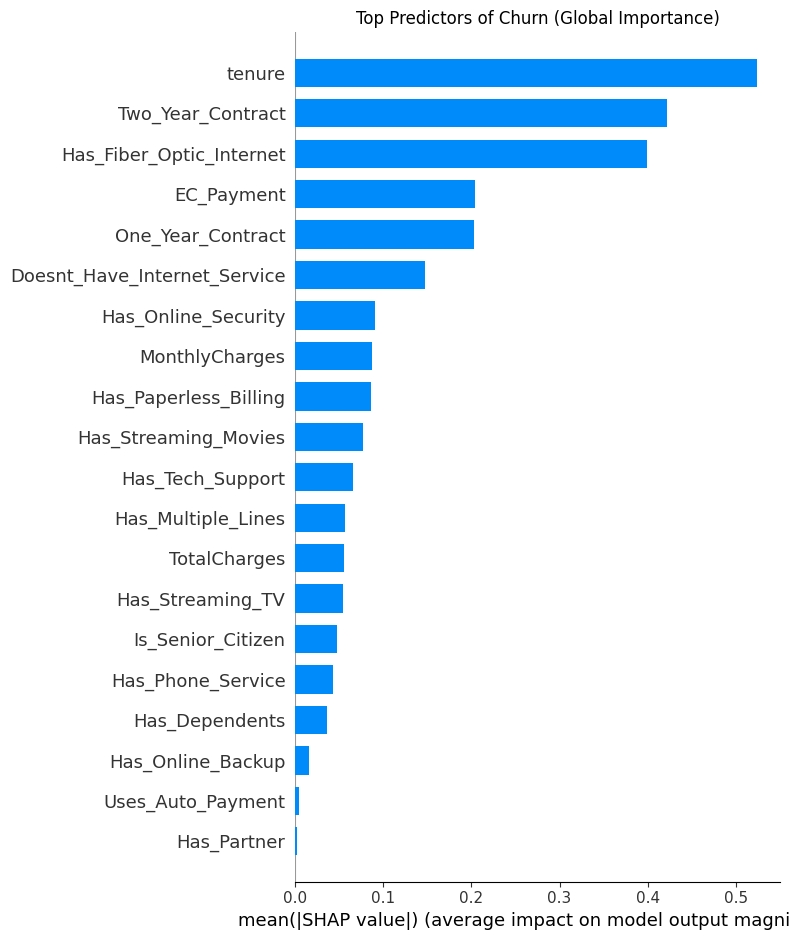

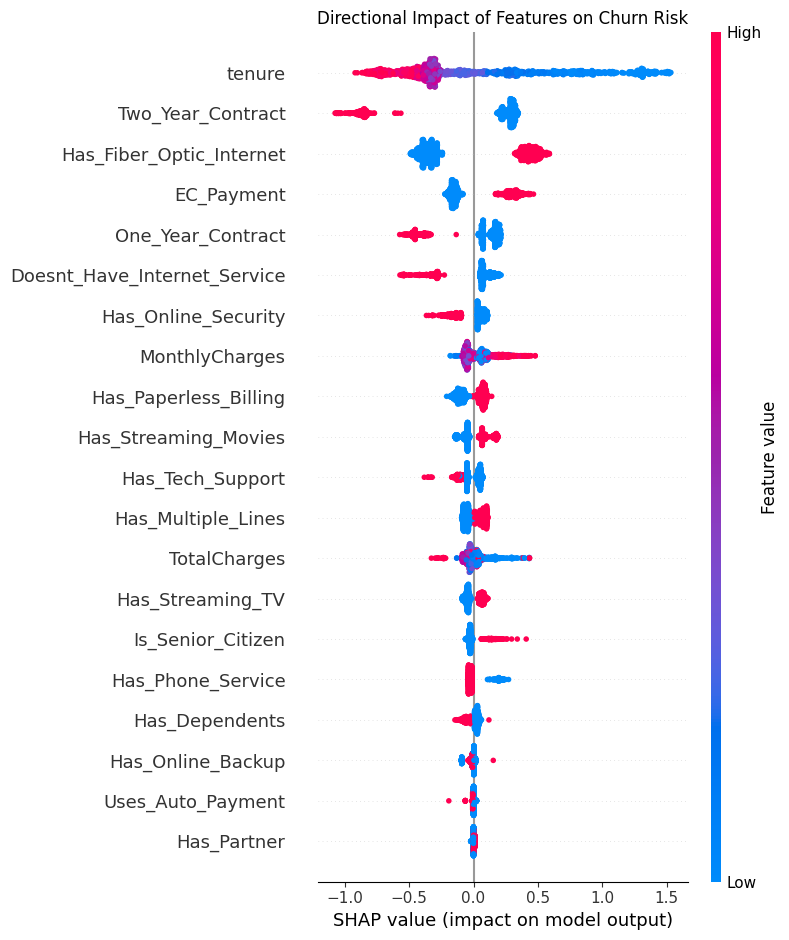


--- Local Explanation for Customer Index 10 ---
Actual Status: Stayed
Model Prediction: 65.90% Probability of Churn


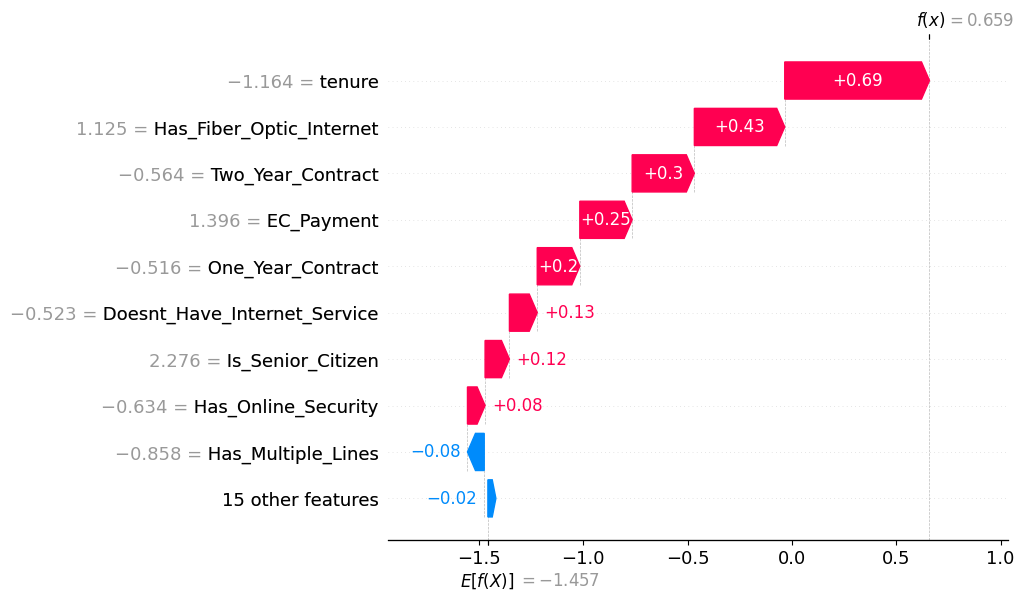

<Figure size 640x480 with 0 Axes>

In [ ]:
# ==========================================
# SHAP Interpretability & Feature Importance
# ==========================================
import shap

# 1. Prepare Data for SHAP
# We need to convert the scaled numpy array back to a DataFrame with column names
# so the plots are readable (e.g., "TotalCharges" instead of "Feature 5")
X_test_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)

# 2. Initialize the Explainer
# We use the 'best_gb_model' (Optimized Model)
explainer = shap.TreeExplainer(best_gb_model)
shap_values = explainer.shap_values(X_test_df)

# --- A. Global Feature Importance (Bar Chart) ---
plt.figure(figsize=(10, 8))
plt.title("Top Predictors of Churn (Global Importance)")
shap.summary_plot(shap_values, X_test_df, plot_type="bar", show=False)
plt.savefig('global_shap.png')
plt.show()

# --- B. SHAP Summary Plot (Beeswarm) ---
# This shows the DIRECTION of the impact (Red = High Value, Blue = Low Value)
plt.figure(figsize=(12, 8))
plt.title("Directional Impact of Features on Churn Risk")
shap.summary_plot(shap_values, X_test_df, show=False)
plt.savefig('shap_directional.png')
plt.show()

# --- C. Local Interpretability (Single Customer) ---
customer_idx = 10
customer_data = X_test_df.iloc[customer_idx]
actual_label = y_test.iloc[customer_idx]
model_prob = best_gb_model.predict_proba(X_test_scaled)[customer_idx, 1]

print(f"\n--- Local Explanation for Customer Index {customer_idx} ---")
print(f"Actual Status: {'Churned' if actual_label==1 else 'Stayed'}")
print(f"Model Prediction: {model_prob:.2%} Probability of Churn")

# Force Plot
plt.figure(figsize=(10, 6))
shap.plots.waterfall(
    shap.Explanation(values=shap_values[customer_idx],
                     base_values=explainer.expected_value,
                     data=customer_data,
                     feature_names=X_test_df.columns)
)
plt.savefig('local_shap.png')
plt.show()

In [ ]:
original_df = pd.read_csv('Cleaned_Dataset.csv')
customer_data = original_df[original_df['customerID'] == '7044-YAACC'].iloc[0]
print(f"--- Data for customerID 7044-YAACC ---")
for col_name, value in customer_data.items():
    print(f"{col_name}: {value}")

--- Data for customerID 7044-YAACC ---
customerID: 7044-YAACC
tenure: 4
MonthlyCharges: 70.2
TotalCharges: 280.35
Churn: 0
Is_Male: 1
Is_Senior_Citizen: 1
Has_Partner: 1
Has_Dependents: 0
Has_Phone_Service: 1
Has_Multiple_Lines: 0
Has_Online_Security: 0
Has_Online_Backup: 0
Has_Device_Protection: 0
Has_Tech_Support: 0
Has_Streaming_TV: 0
Has_Streaming_Movies: 0
Has_Fiber_Optic_Internet: 1
Doesnt_Have_Internet_Service: 0
One_Year_Contract: 0
Two_Year_Contract: 0
CC_Payment: 0
EC_Payment: 1
MC_Payment: 0
Uses_Auto_Payment: 0
Has_Paperless_Billing: 1
